<h1><center> Drug Reviews - Alexander Levitt </center></h1>

### Abstract: 
Every day, people around the world take doctor prescribed medications to help deal with a variety of diagnoses. I have always wondered how a doctor decides what to prescribe. In this project,  I will build machine learning models that “play doctor”! Through utilizing text analytics techniques on patient reviews my models will predict a patient condition and the effectiveness of the treatment (rating). 

### Introduction:
In this project, I explore a data-set of over 200,000 drug reviews that was the basis for a recent Kaggle competition. The data set was adapted from the Machine Learning Library at UC Irvine where it was generated through web scraping pharmaceutical reviews . It was first published  in a study that looked at sentiment analysis of drug experiences across multiple facets. Medication feedback from customers is extremely helpful for drug companies, doctors, and pharmacists alike who are interested in knowing what drugs are effective and what their side-effects can be. 

In [2]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS


import warnings
warnings.filterwarnings('ignore')

# Regex library to clean data 
import re, string, gc  

# pretty printing for better legibility
import pprint

# Natural Language Tool Kit 
import nltk  
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

# Vader Sentiment Analysis Tool
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Web Scrapping Clearner
from bs4 import BeautifulSoup

# Progress bar
from tqdm import tqdm, tqdm_notebook
# Instantiate
tqdm.pandas(tqdm_notebook)

In [3]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import log_loss, confusion_matrix, classification_report, roc_curve,auc, accuracy_score, recall_score
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


from sklearn.svm import SVC
from sklearn import svm
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [4]:
# Load the data
train = pd.read_csv('drugs_train.csv')
test = pd.read_csv('drugs_test.csv')

# Exploratory Data Analysis

In [5]:
print(f'Data Frame has: \n{train.shape[0]} rows \n{train.shape[1]} columns')
print(f'Data Frame has: \n{test.shape[0]} rows \n{test.shape[1]} columns')

Data Frame has: 
161297 rows 
7 columns
Data Frame has: 
53766 rows 
7 columns


In [6]:
train.head(5)

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [7]:
list(train) == list(test)

True

In [9]:
print(train.nunique())
print('-'*40)
print(test.nunique())

uniqueID       161297
drugName         3436
condition         884
review         112329
rating             10
date             3579
usefulCount       389
dtype: int64


In [10]:
print(test.nunique())

uniqueID       53766
drugName        2637
condition        708
review         48280
rating            10
date            3566
usefulCount      325
dtype: int64


In [11]:
train.shape[0]/test.shape[0] # The training set is 3x the test (75% train and 25% test split)

2.999981400885318

In [12]:
train.drop(columns = ['uniqueID'], inplace=True) # All rows have their own unique column. No reason to keep it.
test.drop(columns = ['uniqueID'], inplace=True) # All rows have their own unique column. No reason to keep it.

In [13]:
train.head()

,drugName,condition,review,rating,date,usefulCount
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [15]:
test.head()

,drugName,condition,review,rating,date,usefulCount
0,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4


In [16]:
print(train.isna().sum().sort_values(ascending = False))
total = train.isnull().sum().sort_values(ascending = False)
percent = (train.isnull().sum()/train.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent Missing'])
(missing_data)

condition      899
usefulCount      0
date             0
rating           0
review           0
drugName         0
dtype: int64


,Total,Percent Missing
condition,899,0.557357
usefulCount,0,0.000000
date,0,0.000000
rating,0,0.000000
review,0,0.000000
drugName,0,0.000000


Only .55% of the data is missing. I could impute the condition with the mode or with other techniques but given how small the ammount is, I am going to drop it.

In [17]:
print(train.shape)
train = train.dropna(axis=0)
print(train.shape)

(161297, 6)
(160398, 6)


In [18]:
print(test.isnull().sum().sort_values(ascending = False))
total = test.isnull().sum().sort_values(ascending = False)
percent = (test.isnull().sum()/test.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent Missing'])
missing_data

condition      295
usefulCount      0
date             0
rating           0
review           0
drugName         0
dtype: int64


,Total,Percent Missing
condition,295,0.548674
usefulCount,0,0.000000
date,0,0.000000
rating,0,0.000000
review,0,0.000000
drugName,0,0.000000


In [19]:
print(test.shape)
test = test.dropna(axis=0)
print(test.shape)

(53766, 6)
(53471, 6)


In [20]:
train_conditions = train.condition.value_counts().sort_values(ascending=False)
test_conditions = test.condition.value_counts().sort_values(ascending=False)
print(train_conditions[:10])  # Get the top 10 conditions
print('-'*40)
print(test_conditions[:10])

Birth Control      28788
Depression          9069
Pain                6145
Anxiety             5904
Acne                5588
Bipolar Disorde     4224
Insomnia            3673
Weight Loss         3609
Obesity             3568
ADHD                3383
Name: condition, dtype: int64
----------------------------------------
Birth Control      9648
Depression         3095
Pain               2100
Anxiety            1908
Acne               1847
Bipolar Disorde    1380
Weight Loss        1248
Insomnia           1231
Obesity            1189
ADHD               1126
Name: condition, dtype: int64


In [21]:
# Bipolar Disorder was spelled wrong...let's fix that.
train['condition'] = train['condition'].str.replace('Disorde', 'Disorder')
test['condition'] = test['condition'].str.replace('Disorde', 'Disorder')

In [22]:
# Double check the columns are equal
test.columns = train.columns

# Concat the dataframe row wise
bigdata = pd.concat([train, test], ignore_index=True)

display(bigdata.head(10))
print(bigdata.shape)

,drugName,condition,review,rating,date,usefulCount
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37
5,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,28-Nov-15,43
6,Levonorgestrel,Emergency Contraception,"""He pulled out, but he cummed a bit in me. I t...",1,7-Mar-17,5
7,Aripiprazole,Bipolar Disorder,"""Abilify changed my life. There is hope. I was...",10,14-Mar-15,32
8,Keppra,Epilepsy,""" I Ve had nothing but problems with the Kepp...",1,9-Aug-16,11
9,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8,8-Dec-16,1


(213869, 6)


In [23]:
# LETS CONVERT TO DATETIME SO WE CAN SPLIT THE DATE INTO DAY, MONTH, YEAR. PERHAPS THERE IS SOMETHING USEFUL IN
# LOOKING AT WHEN REVIEWS WERE WRITTEN. 

bigdata['date'] = pd.to_datetime(bigdata['date'])
bigdata['day'] = bigdata['date'].dt.day
bigdata['month'] = bigdata['date'].dt.month
bigdata['year'] = bigdata['date'].dt.year

In [24]:
bigdata.nunique()

drugName         3667
condition         916
review         128449
rating             10
date             3579
usefulCount       397
day                31
month              12
year               10
dtype: int64

In [25]:
print(f'Cases of duplicate:' , len(bigdata[bigdata.duplicated(['drugName','review'])]))

Cases of duplicate: 133


In [26]:
bigdata=bigdata.drop_duplicates(['drugName','review'])
bigdata=bigdata.reset_index(drop=True)

In [27]:
bigdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213736 entries, 0 to 213735
Data columns (total 9 columns):
drugName       213736 non-null object
condition      213736 non-null object
review         213736 non-null object
rating         213736 non-null int64
date           213736 non-null datetime64[ns]
usefulCount    213736 non-null int64
day            213736 non-null int64
month          213736 non-null int64
year           213736 non-null int64
dtypes: datetime64[ns](1), int64(5), object(3)
memory usage: 14.7+ MB


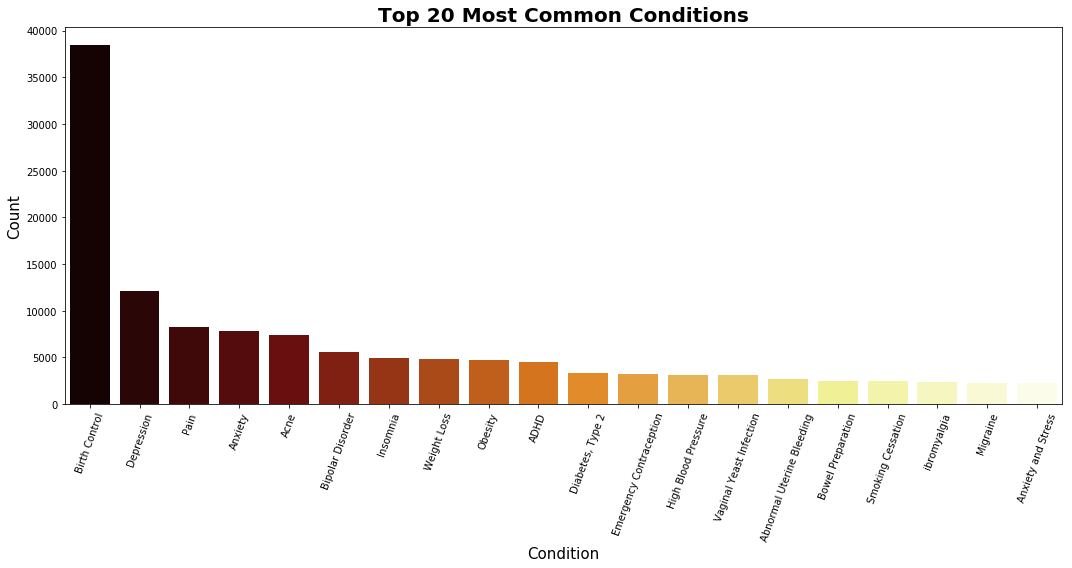

In [28]:
plt.figure(figsize= (15,8))
sns.countplot(x = bigdata['condition'], order = bigdata.condition.value_counts().index[:20], palette='afmhot')
plt.title('Top 20 Most Common Conditions', fontweight= 'bold', size=20 )
plt.xlabel('Condition', size=15)
plt.ylabel('Count', size=15)
plt.xticks(rotation=70)
plt.tight_layout()
plt.show();

In [29]:
# THERE IS A SPELLING MISTAKE WITH FIBROMYALGIA
bigdata['condition'] = bigdata['condition'].str.replace('ibromyalgia', 'Fibromyalgia')

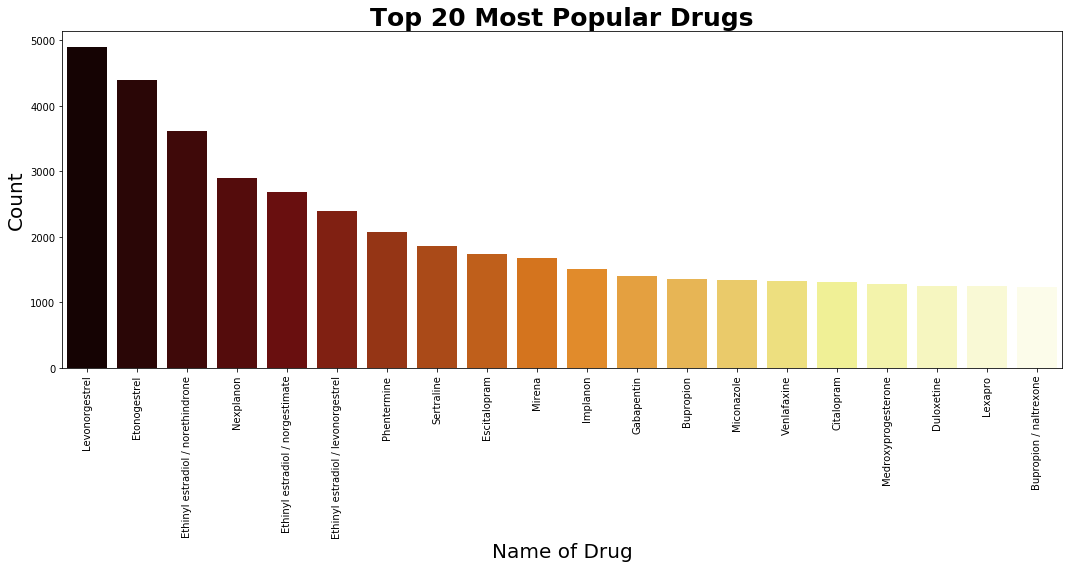

In [30]:
plt.figure(figsize= (15,8))
sns.countplot(x = bigdata['drugName'], order = bigdata.drugName.value_counts().index[:20], palette='afmhot')
plt.title('Top 20 Most Popular Drugs', fontweight= 'bold', size=25 )
plt.xlabel('Name of Drug', size=20)
plt.ylabel('Count', size=20)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show();

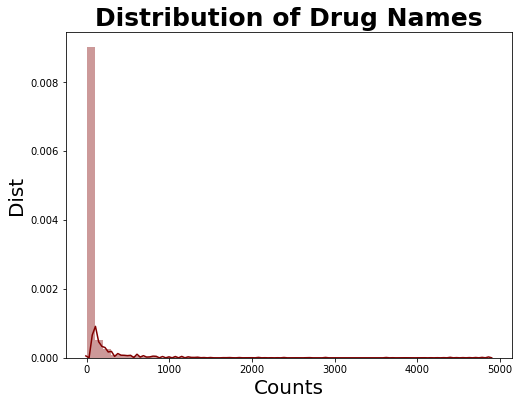

In [31]:
drugs = bigdata['drugName'].value_counts()
plt.figure(figsize=(8, 6))
sns.distplot(drugs, bins=50, kde=True, color='maroon')
plt.xlabel('Counts', fontsize=20)
plt.ylabel('Dist', fontsize=20)
plt.title("Distribution of Drug Names", fontweight= "bold", size=25 )
plt.show();
# There is a significant right skew (positive skew) in the data set. Certain drugs are used a lot more than others.

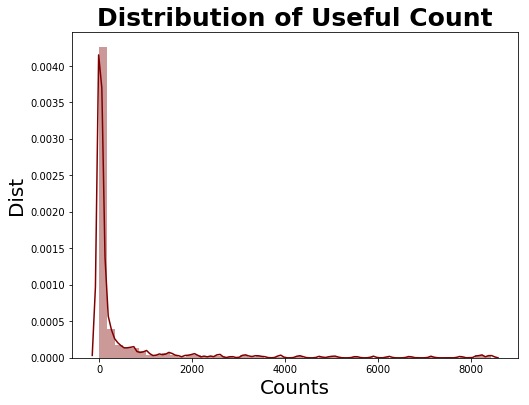

In [32]:
drugs = bigdata['usefulCount'].value_counts()
plt.figure(figsize=(8, 6))
sns.distplot(drugs, bins=50, kde=True, color='maroon')
plt.xlabel('Counts', fontsize=20)
plt.ylabel('Dist', fontsize=20)
plt.title("Distribution of Useful Count", fontweight= "bold", size=25 )
plt.show();

In [33]:
# Note that useful count is for how many people found a review to be useful. The high useful counts are for 
# the most common drugs, conditions.

Text(0.5, 1.0, 'Top 20 : The number of drugs per condition.')

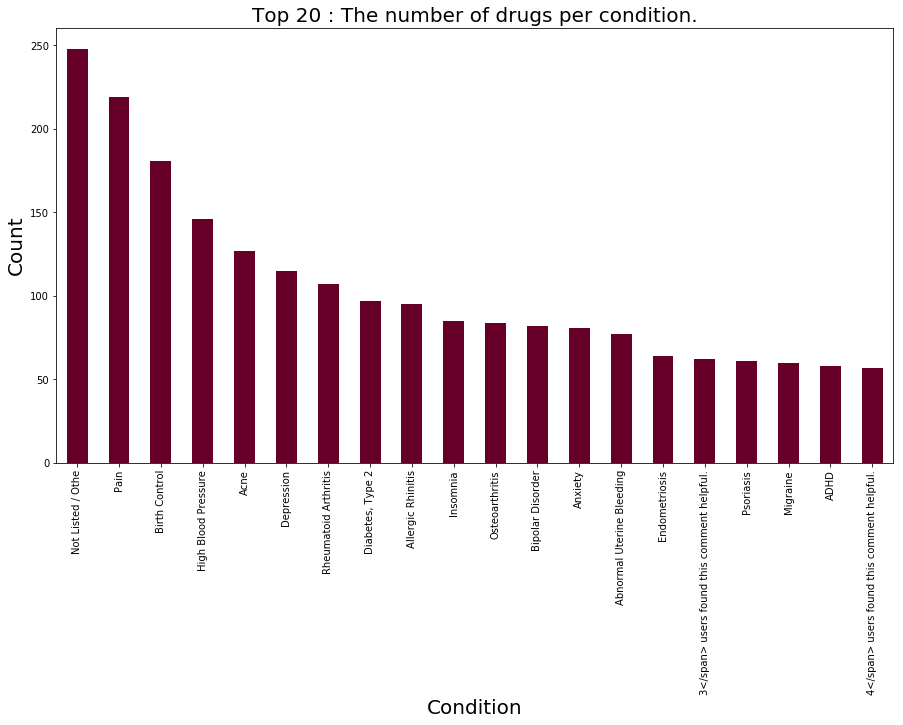

In [34]:
dpc = bigdata.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
dpc[0:20].plot(kind="bar", figsize = (15,8), fontsize = 10,color="#660029")
plt.xlabel("Condition", fontsize = 20)
plt.ylabel("Count", fontsize = 20)
plt.title("Top 20 : The number of drugs per condition.", fontsize = 20)

In [35]:
# Notice above the htlm code 3</span>, 4</span> is showing up in the top 20 conditions. 
# I will address this in later steps.

In [36]:
bigdata['condition'] = bigdata['condition'].str.replace('Cance', 'Cancer')

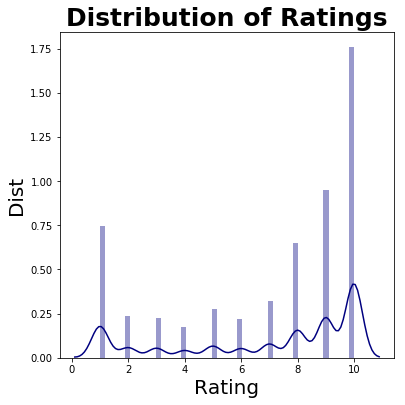

In [37]:
# Notice the bimodal distribution to the ratings. The top ratings are 8-9-10 and then 1. 
plt.figure(figsize=(6,6))
sns.distplot(bigdata['rating'], color='navy')
plt.xlabel('Rating', fontsize=20)
plt.ylabel('Dist', fontsize=20)
plt.title("Distribution of Ratings", fontweight= "bold", size=25 )
plt.show();

In [38]:
# As seen above 3</span> users found this comment helpful is also a condition. This is a top 20 condition!
# The conditions above show "3</span> users found this comment helpful" appears as a condition. I need to clean this up.
len(bigdata[bigdata['condition'].str.contains("</span>")])

1171

In [39]:
all_list = set(bigdata.index)
span_list = []
for i,j in enumerate(bigdata['condition']):
    if '</span>' in j:
        span_list.append(i)
new_idx = all_list.difference(set(span_list))
bigdata = bigdata.iloc[list(new_idx)].reset_index()
del bigdata['index']

In [40]:
len(bigdata[bigdata['condition'].str.contains("</span>")])

0

In [2]:
plt.figure(figsize=(6,6))
sns.set_palette("seismic_r", 8, .75)
sns.scatterplot(x='rating',y='usefulCount',data=bigdata)
plt.title('Useful Count vs Rating', fontweight='bold', size=15)
plt.xlabel('Rating', size=15)
plt.ylabel('Average Useful Count', size=15)
plt.xticks([i for i in range(1, 11)]);

NameError: name 'plt' is not defined

(-0.5, 399.5, 199.5, -0.5)

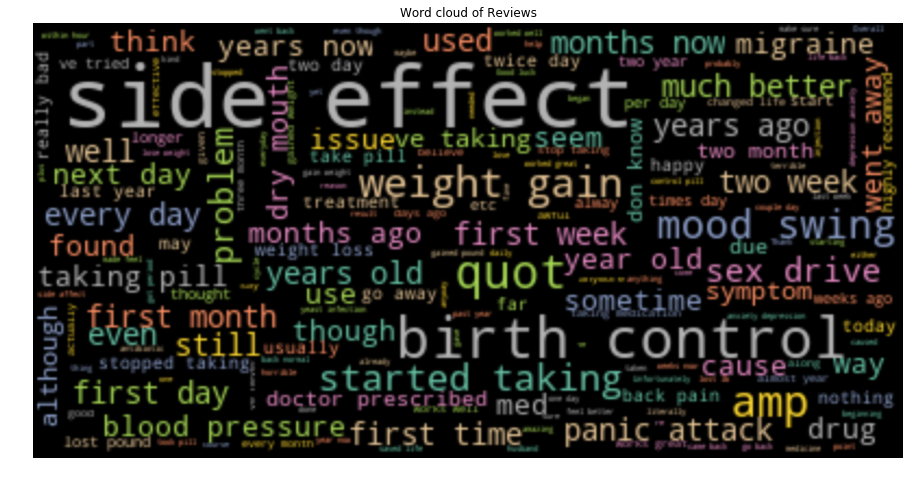

In [42]:
from wordcloud import WordCloud, STOPWORDS

plt.figure(figsize= (16,8))
plt.title('Word cloud of Reviews')
wc = WordCloud(max_words=1000 ,max_font_size=40, background_color='black', stopwords = STOPWORDS, colormap='Set2')
wc.generate(' '.join(bigdata['review']))
plt.imshow(wc,interpolation="gaussian")
plt.axis('off')

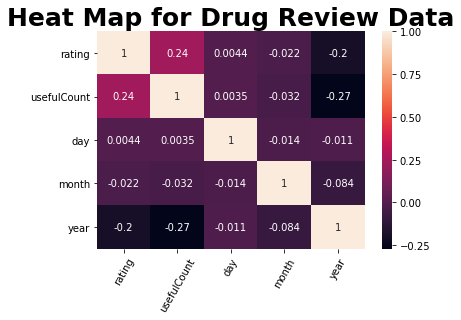

In [40]:
corr = bigdata.corr()
sns.heatmap(corr, annot = True)
plt.xticks(rotation = 60)
plt.title("Heat Map for Drug Review Data",  fontweight="bold", size=25)
plt.show() 

In [41]:
# Interesting that year has a correlation coefficient of -.2. 

Text(0.5, 1.0, 'Mean rating in year')

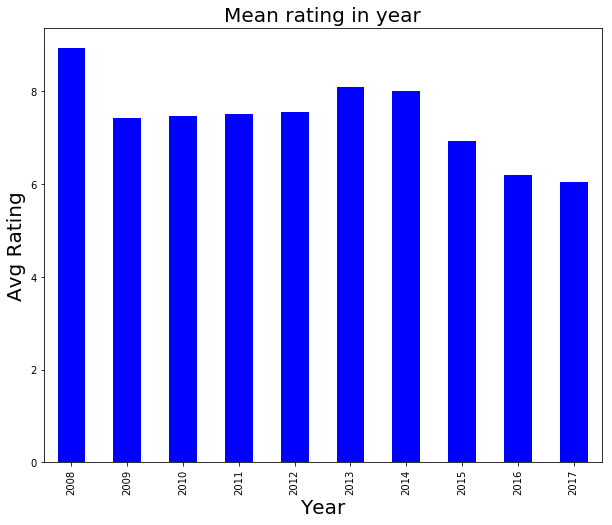

In [42]:
rating = bigdata.groupby('year')['rating'].mean()
rating.plot(kind="bar", figsize = (10,8), fontsize = 10,color="blue")
plt.xlabel("Year", fontsize = 20)
plt.ylabel("Avg Rating", fontsize = 20)
plt.title("Mean rating in year", fontsize = 20)

In [43]:
# Average rating has decreased year over year

In [45]:
useful = bigdata.sort_values(by='usefulCount', ascending=False)
useful.reset_index(drop=True)

,drugName,condition,review,rating,date,usefulCount,day,month,year
0,Sertraline,Depression,"""I remember reading people&#039;s opinions, on...",10,2008-07-31,1291,31,7,2008
1,Zoloft,Depression,"""I remember reading people&#039;s opinions, on...",10,2008-07-31,1291,31,7,2008
2,Mirena,Birth Control,"""I have had my IUD for over a year now and I t...",10,2009-04-01,1247,1,4,2009
3,Levonorgestrel,Birth Control,"""I have had my IUD for over a year now and I t...",10,2009-04-01,1247,1,4,2009
4,Sertraline,Depression,"""I&#039;ve been on Zoloft 50mg for over two ye...",9,2008-08-05,949,5,8,2008
5,Zoloft,Depression,"""I&#039;ve been on Zoloft 50mg for over two ye...",9,2008-08-05,949,5,8,2008
6,Phentermine,Weight Loss,"""I have used this pill off and on for the past...",10,2008-10-19,796,19,10,2008
7,Adipex-P,Weight Loss,"""I have used this pill off and on for the past...",10,2008-10-19,796,19,10,2008
8,Citalopram,Depression,"""I responded after one week. The side effects ...",8,2008-03-25,771,25,3,2008
9,Celexa,Depression,"""I responded after one week. The side effects ...",8,2008-03-25,771,25,3,2008


In [46]:
# Look at the top 5 reviews by useful count
for x in useful.review.iloc[:5]:
    print(x, '\n')
# The reviews match for 1 and 2. As well as 3 and 4. It appears however that they are for two different drugs but the same review!
# Upon further research however, I learned that Zoloft is a brand name and Sertaline is the generic drug. While a duplicate rows, 
# wouldn't catch this, having some domain knowledge is really helpful. This is the same with Mirena and Levonrgestrel.
# What should we do here?

"I remember reading people&#039;s opinions, online, of the drug before I took it and it scared me away from it. Then I finally decided to give it a try and it has been the best choice I have made. I have been on it for over 4 months and I feel great. I&#039;m on 100mg and I don&#039;t have any side effects. When I first started I did notice that my hands would tremble but then it subsided. So honestly, don&#039;t listen to all the negativity because what doesn&#039;t work for some works amazing for others. So go based on youself and not everyone else. It may be a blessing in diguise. The pill is not meant to make you be all happy go lucky and see &quot;butterflies and roses&quot;, its meant to help put the chemicals in your mind in balance so you can just be who you are and not overly depressed. I still get sad some times, but that is normal, that is life, and it&#039;s up to people to take control to make a change. I did so by getting on this pill." 

"I remember reading people&#039;s

In [47]:
print(bigdata.shape)
print(f'Cases of duplicate:' , bigdata[bigdata.duplicated(subset=['condition', 'review', 'rating', 'date', 'usefulCount'], keep='first')].shape[0])

(212565, 9)
Cases of duplicate: 84638


In [48]:
print(f' The percentage of our rows that are duplicates:', (84638/212565*100))

 The percentage of our rows that are duplicates: 39.81746759814645


### I am going to start off by keeping the first instance of these duplicates, and dropping the rest. While we are dropping 39.8% of our data set, there is no reason to keep duplicates.

In [49]:
bigdata = bigdata.drop_duplicates(subset=['condition', 'review', 'rating', 'date', 'usefulCount'], keep='first')
len(bigdata)

127927

In [50]:
bigdata=bigdata.reset_index(drop=True)
bigdata.head(10)

,drugName,condition,review,rating,date,usefulCount,day,month,year
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27,20,5,2012
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192,27,4,2010
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17,14,12,2009
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03,10,3,11,2015
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37,27,11,2016
5,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,2015-11-28,43,28,11,2015
6,Levonorgestrel,Emergency Contraception,"""He pulled out, but he cummed a bit in me. I t...",1,2017-03-07,5,7,3,2017
7,Aripiprazole,Bipolar Disorder,"""Abilify changed my life. There is hope. I was...",10,2015-03-14,32,14,3,2015
8,Keppra,Epilepsy,""" I Ve had nothing but problems with the Kepp...",1,2016-08-09,11,9,8,2016
9,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8,2016-12-08,1,8,12,2016


Text(0, 0.5, 'Distribution')

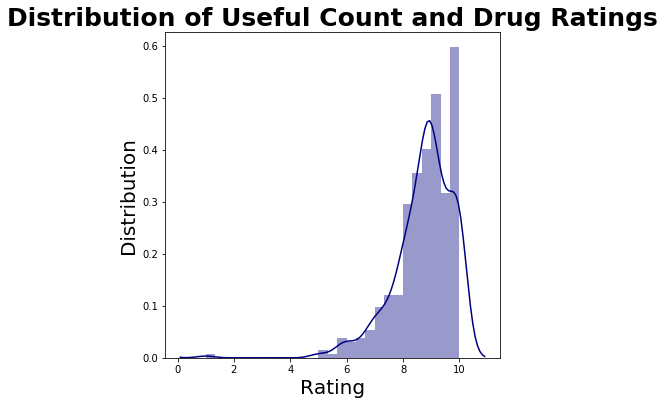

In [51]:
uc_rating_avgs = (bigdata['rating'].groupby(bigdata['usefulCount']).mean())
plt.figure(figsize=(6,6))
sns.distplot(uc_rating_avgs, color='navy')
plt.title('Distribution of Useful Count and Drug Ratings', fontweight= "bold", size=25)
plt.xlabel('Rating', fontsize=20)
plt.ylabel('Distribution', fontsize=20)

In [52]:
# Reviewers find higher ratings to be more useful than lower ratings! Does this show an inherent bias?
# The distplot above shows us that we have very similar distributions of the ratings per drug name.

In [53]:
bigdata.nunique()

drugName         3169
condition         836
review         127285
rating             10
date             3579
usefulCount       397
day                31
month              12
year               10
dtype: int64

In [54]:
# What are the most popular pairings of drugs and conditions.
pairings = bigdata.groupby(['condition','drugName']).size().sort_values(ascending=False)
pairings[0:20]

condition                drugName                          
Birth Control            Etonogestrel                          2219
                         Ethinyl estradiol / norethindrone     1494
                         Nexplanon                             1436
Weight Loss              Phentermine                           1429
Birth Control            Levonorgestrel                        1423
Vaginal Yeast Infection  Miconazole                            1162
Birth Control            Ethinyl estradiol / levonorgestrel    1113
                         Ethinyl estradiol / norgestimate      1106
Vaginal Yeast Infection  Tioconazole                            977
Emergency Contraception  Levonorgestrel                         881
Birth Control            Implanon                               738
                         Mirena                                 664
Smoking Cessation        Varenicline                            632
Birth Control            Skyla                          

In [55]:
bigdata['pop_w_cond']=(bigdata.condition.map(bigdata.groupby(['condition']).size()))
bigdata['total_users'] = bigdata.drugName.map(bigdata.groupby(['drugName']).size())

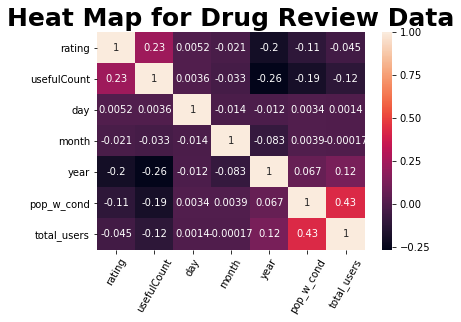

In [56]:
corr = bigdata.corr()
sns.heatmap(corr, annot = True)
plt.xticks(rotation = 60)
plt.title("Heat Map for Drug Review Data",  fontweight="bold", size=25)
plt.show() 

## Sentiment Analysis and Text Preprocessing

In [57]:
# Lets use VADER! 

analyzer = SentimentIntensityAnalyzer()

sentiments = []

#Note that vader's lexicon is designed to remove stopwords, punctuation, numbers, accents, etc. Let's see!
for i in bigdata.review:
    sentiments.append(analyzer.polarity_scores(i).get('compound'))
    
sentiments = np.array(sentiments)

In [58]:
bigdata['vader_sentiment_score'] = sentiments
bigdata = bigdata.sort_values(by='usefulCount', ascending=False).reset_index(drop=True)
bigdata.head()

,drugName,condition,review,rating,date,usefulCount,day,month,year,pop_w_cond,total_users,vader_sentiment_score
0,Sertraline,Depression,"""I remember reading people&#039;s opinions, on...",10,2008-07-31,1291,31,7,2008,7112,1296,0.9772
1,Mirena,Birth Control,"""I have had my IUD for over a year now and I t...",10,2009-04-01,1247,1,4,2009,19525,830,0.7739
2,Zoloft,Depression,"""I&#039;ve been on Zoloft 50mg for over two ye...",9,2008-08-05,949,5,8,2008,7112,563,-0.6815
3,Adipex-P,Weight Loss,"""I have used this pill off and on for the past...",10,2008-10-19,796,19,10,2008,3111,237,0.7921
4,Citalopram,Depression,"""I responded after one week. The side effects ...",8,2008-03-25,771,25,3,2008,7112,1003,-0.7227


In [59]:
# Note that despite the high ratings that are appearing in the head with the top usefulCount, we still have 
# some negative sentiment scores.

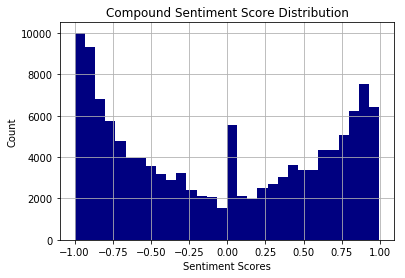

In [60]:
bigdata.vader_sentiment_score.hist(color='navy', bins=30)
plt.title('Compound Sentiment Score Distribution')
plt.xlabel('Sentiment Scores')
plt.ylabel('Count');

In [61]:
# It is is interesting to note that despite having way more positive ratings, in our data set, it appears like
# we have more negative sentiments.

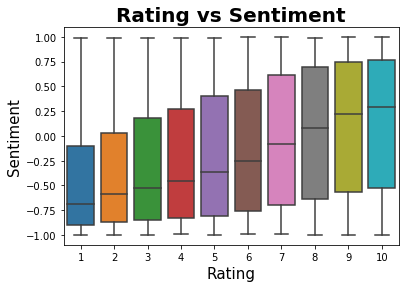

In [62]:
sns.boxplot(x = bigdata.rating, y = bigdata.vader_sentiment_score)
plt.title('Rating vs Sentiment', fontweight='bold', size=20)
plt.xlabel('Rating', size=15)
plt.ylabel('Sentiment', size=15)
plt.show()

In [63]:
# For each rating, we still found both positive and negative sentiments. This sentiment analysis is more geared 
# toward finding negative snetiments, which makes sense based on the histogram. 

# We can see that the median for the lower sentiments is stronger for negative ratings (means between -.5 and -.75). 
# However the median of the most positive ratings (9 and 10) which are between 0 and .25. 

# Also the variance (the size of each box) increases as we become more positive in rating. Notice that the sentiment
# for 1 is never greater thna 0. However, for 10, the variance is from -.5 to +.75.

In [63]:
positive_num = len(bigdata[bigdata['vader_sentiment_score'] >=0.05])
neutral_num = len(bigdata[(bigdata['vader_sentiment_score'] >-0.05) & (bigdata['vader_sentiment_score']<0.05)])
negative_num = len(bigdata[bigdata['vader_sentiment_score']<=-0.05])

In [64]:
positive_num, neutral_num, negative_num 

(57121, 6120, 64686)

In [65]:
bigdata['vader_sentiment_label']= bigdata['vader_sentiment_score'].apply(lambda x:str('positive') if x>=0.05 else str('negative') if x<=-0.05 else str('neutral'))

In [66]:
bigdata['pos-neg-rating'] = bigdata['rating'].apply(lambda x:str('positive') if x>=9 else str('negative'))
bigdata.head()

,drugName,condition,review,rating,date,usefulCount,day,month,year,pop_w_cond,total_users,vader_sentiment_score,vader_sentiment_label,pos-neg-rating
0,Sertraline,Depression,"""I remember reading people&#039;s opinions, on...",10,2008-07-31,1291,31,7,2008,7112,1296,0.9772,positive,positive
1,Mirena,Birth Control,"""I have had my IUD for over a year now and I t...",10,2009-04-01,1247,1,4,2009,19525,830,0.7739,positive,positive
2,Zoloft,Depression,"""I&#039;ve been on Zoloft 50mg for over two ye...",9,2008-08-05,949,5,8,2008,7112,563,-0.6815,negative,positive
3,Adipex-P,Weight Loss,"""I have used this pill off and on for the past...",10,2008-10-19,796,19,10,2008,3111,237,0.7921,positive,positive
4,Citalopram,Depression,"""I responded after one week. The side effects ...",8,2008-03-25,771,25,3,2008,7112,1003,-0.7227,negative,negative


In [67]:
bigdata['pos-neg-bin'] = bigdata['rating'].apply(lambda x:int('1') if x>=9 else int('0'))
bigdata.head()

,drugName,condition,review,rating,date,usefulCount,day,month,year,pop_w_cond,total_users,vader_sentiment_score,vader_sentiment_label,pos-neg-rating,pos-neg-bin
0,Sertraline,Depression,"""I remember reading people&#039;s opinions, on...",10,2008-07-31,1291,31,7,2008,7112,1296,0.9772,positive,positive,1
1,Mirena,Birth Control,"""I have had my IUD for over a year now and I t...",10,2009-04-01,1247,1,4,2009,19525,830,0.7739,positive,positive,1
2,Zoloft,Depression,"""I&#039;ve been on Zoloft 50mg for over two ye...",9,2008-08-05,949,5,8,2008,7112,563,-0.6815,negative,positive,1
3,Adipex-P,Weight Loss,"""I have used this pill off and on for the past...",10,2008-10-19,796,19,10,2008,3111,237,0.7921,positive,positive,1
4,Citalopram,Depression,"""I responded after one week. The side effects ...",8,2008-03-25,771,25,3,2008,7112,1003,-0.7227,negative,negative,0


In [68]:
bigdata['pos-neg-rating'].value_counts() 
# We have two equal sized classes. Based on a marketing technique called the netpromoter score I decided that
# anything which is a 9 or 10 is positive. While 7 or 8 are often considered passive/neutral, I will call anything
# below 9 as a negative as that is what we saw in the vader sentiment. 

negative    65479
positive    62448
Name: pos-neg-rating, dtype: int64

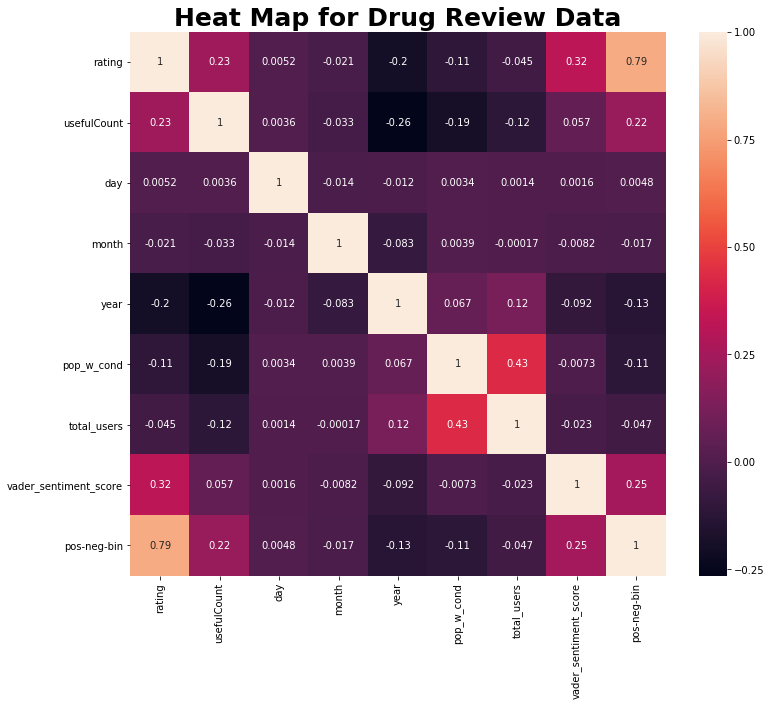

In [69]:
corr = bigdata.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot = True)
plt.xticks(rotation = 90)
plt.title("Heat Map for Drug Review Data",  fontweight="bold", size=25)
plt.show();

In [70]:
# I want to see what the relationship is for sentiment and rating.

In [71]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"(\d)", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),;!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    return df

bigdata = standardize_text(bigdata, "review")

In [72]:
bigdata.head(5)

,drugName,condition,review,rating,date,usefulCount,day,month,year,pop_w_cond,total_users,vader_sentiment_score,vader_sentiment_label,pos-neg-rating,pos-neg-bin
0,Sertraline,Depression,"""I remember reading people ;s opinions, onlin...",10,2008-07-31,1291,31,7,2008,7112,1296,0.9772,positive,positive,1
1,Mirena,Birth Control,"""I have had my IUD for over a year now and I t...",10,2009-04-01,1247,1,4,2009,19525,830,0.7739,positive,positive,1
2,Zoloft,Depression,"""I ;ve been on Zoloft mg for over two years ...",9,2008-08-05,949,5,8,2008,7112,563,-0.6815,negative,positive,1
3,Adipex-P,Weight Loss,"""I have used this pill off and on for the past...",10,2008-10-19,796,19,10,2008,3111,237,0.7921,positive,positive,1
4,Citalopram,Depression,"""I responded after one week The side effects ...",8,2008-03-25,771,25,3,2008,7112,1003,-0.7227,negative,negative,0


In [96]:
# Create StopWords List
stoplist = stopwords.words('english')

from nltk.corpus import stopwords
stoplist = stopwords.words('english')
stoplist.extend(['from', 'mg', 'ive', 'doctor', 'doc', 'pill', 'quot', 're','use','one', 'br', 'po', 'th', 'sayi', 'fo', 'unknown', 'take', 'take', 'taken,' 'get' ])
len(stoplist)

198

In [97]:
# nots are very useful in sentiment analysis
not_stop = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't","mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]
for i in not_stop:
    stoplist.remove(i)
len(stoplist)

178

In [75]:
bigdata.head(5)

,drugName,condition,review,rating,date,usefulCount,day,month,year,pop_w_cond,total_users,vader_sentiment_score,vader_sentiment_label,pos-neg-rating,pos-neg-bin
0,Sertraline,Depression,"""I remember reading people ;s opinions, onlin...",10,2008-07-31,1291,31,7,2008,7112,1296,0.9772,positive,positive,1
1,Mirena,Birth Control,"""I have had my IUD for over a year now and I t...",10,2009-04-01,1247,1,4,2009,19525,830,0.7739,positive,positive,1
2,Zoloft,Depression,"""I ;ve been on Zoloft mg for over two years ...",9,2008-08-05,949,5,8,2008,7112,563,-0.6815,negative,positive,1
3,Adipex-P,Weight Loss,"""I have used this pill off and on for the past...",10,2008-10-19,796,19,10,2008,3111,237,0.7921,positive,positive,1
4,Citalopram,Depression,"""I responded after one week The side effects ...",8,2008-03-25,771,25,3,2008,7112,1003,-0.7227,negative,negative,0


In [76]:
def review_to_wordlist( review, remove_stopwords=False ):
    # Remove HTML
    review_text = BeautifulSoup(review).get_text()
    # Remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
    # Convert words to lower case and split them
    words = review_text.lower().split()
    # Optionally remove stop words (false by default) # I am going to use my previously defined stoplist
    if remove_stopwords:
        words = [w for w in words if not w in stoplist]
    # Return a list of words
    return(' '.join(words))

In [77]:
bigdata['drugs'] = bigdata['drugName'].progress_apply(review_to_wordlist)

100%|██████████| 127927/127927 [00:27<00:00, 4593.90it/s]


In [78]:
# For now I will scrub the text using Stemming

In [79]:
stemmer = SnowballStemmer('english')
def review_to_words(raw_review):
    # 1. Delete HTML 
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. Make a space
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. lower letters
    words = letters_only.lower().split()
    # 4. Stopwords 
    meaningful_words = [w for w in words if not w in stoplist]
    # 5. Stemming
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    # 6. space join words
    return( ' '.join(stemming_words))

In [80]:
bigdata['review_stemmed'] = bigdata['review'].progress_apply(review_to_words)

100%|██████████| 127927/127927 [02:06<00:00, 1009.42it/s]


In [81]:
bigdata.head()

,drugName,condition,review,rating,date,usefulCount,day,month,year,pop_w_cond,total_users,vader_sentiment_score,vader_sentiment_label,pos-neg-rating,pos-neg-bin,drugs,review_stemmed
0,Sertraline,Depression,"""I remember reading people ;s opinions, onlin...",10,2008-07-31,1291,31,7,2008,7112,1296,0.9772,positive,positive,1,sertraline,rememb read peopl opinion onlin drug took scar...
1,Mirena,Birth Control,"""I have had my IUD for over a year now and I t...",10,2009-04-01,1247,1,4,2009,19525,830,0.7739,positive,positive,1,mirena,iud year think best thing ever first got put b...
2,Zoloft,Depression,"""I ;ve been on Zoloft mg for over two years ...",9,2008-08-05,949,5,8,2008,7112,563,-0.6815,negative,positive,1,zoloft,zoloft two year relax easi go person zoloft pr...
3,Adipex-P,Weight Loss,"""I have used this pill off and on for the past...",10,2008-10-19,796,19,10,2008,3111,237,0.7921,positive,positive,1,adipex p,use past year say best lose weight thing ever ...
4,Citalopram,Depression,"""I responded after one week The side effects ...",8,2008-03-25,771,25,3,2008,7112,1003,-0.7227,negative,negative,0,citalopram,respond week side effect lethargi bowel proble...


In [82]:
def review_to_wordlist( review, remove_stopwords=True ):
    # Remove HTML
    review_text = BeautifulSoup(review).get_text()
    # Remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
    # Convert words to lower case and split them
    words = review_text.lower().split()
    # Optionally remove stop words (false by default) # I am going to use my previously defined stoplist
    if remove_stopwords:
        words = [w for w in words if not w in stoplist]
    # Return a list of words
    return(' '.join(words))

In [83]:
bigdata['clean_no_stem'] = bigdata['review'].progress_apply(review_to_wordlist)

100%|██████████| 127927/127927 [00:52<00:00, 2418.83it/s]


In [85]:
def review_to_wordlist( condition, remove_stopwords=False ):
    # Remove HTML
    review_text = BeautifulSoup(condition).get_text()
    # Remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
    # Convert words to lower case and split them
    words = review_text.lower().split()
    # Optionally remove stop words (false by default) # I am going to use my previously defined stoplist
    if remove_stopwords:
        words = [w for w in words if not w in stoplist]
    # Return a list of words
    return(' '.join(words))

In [86]:
bigdata['clean_condition'] = bigdata['condition'].progress_apply(review_to_wordlist)

100%|██████████| 127927/127927 [00:28<00:00, 4417.19it/s]


In [87]:
len(bigdata[bigdata.clean_condition.str.contains("</span> users found this comment helpful")])

0

## Vader Analysis

In [88]:
bigdata.shape

(127927, 19)

In [89]:
bigdata.to_csv("bigdata_clean.csv") # save scrubbed dataframe locally

In [90]:
# USING VADER SENTIMENT TO PREDICT THE RATING 

In [91]:
X = bigdata[["vader_sentiment_score"]]
y = bigdata['pos-neg-bin']

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=.25, random_state=42)

# First we set up our pipeline for analysis


scaler = StandardScaler()
logreg = LogisticRegression()
estimators = [('scaler', scaler) , ('logreg', logreg)]

# Create our actual pipeline

pipe = Pipeline(estimators)

In [93]:
# Now we set up our grid search
params = {'logreg__C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
         'logreg__solver': ['saga', 'liblinear'],
         'logreg__penalty': ['l1','l2'] }
# Instantiate our grid searcher
grid_search = GridSearchCV(pipe, param_grid = params, scoring = 'f1', cv=5, verbose=True)
# Fit our searcher to our data
fitted_search = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   42.1s finished


In [94]:
from sklearn.metrics import f1_score
# Look at the hyperparameters it found
display(fitted_search.best_estimator_)
# Calculate its predicted values on our test set
y_pred = fitted_search.best_estimator_.predict(X_test)
# Look at some evaluations metrics
print('f1:', f1_score(y_test, y_pred))
print('Confusion mattrix:\n', confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logreg', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))])

f1: 0.598404085541015
Confusion mattrix:
 [[10026  6368]
 [ 6214  9374]]
              precision    recall  f1-score   support

           0       0.62      0.61      0.61     16394
           1       0.60      0.60      0.60     15588

   micro avg       0.61      0.61      0.61     31982
   macro avg       0.61      0.61      0.61     31982
weighted avg       0.61      0.61      0.61     31982



In [104]:
X = bigdata[["vader_sentiment_score"]]
y = bigdata['pos-neg-bin']

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=.25, random_state=42)

# First we set up our pipeline for analysis


rfc=RandomForestClassifier(random_state=42)


# Now we set up our grid search
params = {      
                'n_estimators': [300,400,500],
                'max_features': ['auto', 'sqrt', 'log2'],
                'max_depth' : [5,6,7,8],
                'criterion' : ['gini', 'entropy']
         }

CV_rfc = GridSearchCV(estimator=rfc, param_grid=params, cv= 5, verbose=5, n_jobs= -1)

CV_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 26.1min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 47.5min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 217.6min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [300, 400, 500], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [5, 6, 7, 8], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=5)

In [105]:
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 300}

In [107]:
rfc1=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 300, 
                            max_depth=8, criterion='entropy')

rfc1.fit(X_train, y_train)

y_pred=rfc1.predict(X_test)

print("F1_Score for Random Forest on CV data: ",f1_score(y_test,y_pred))
print('Confusion mattrix:\n', confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

F1_Score for Random Forest on CV data:  0.570672349786883
Confusion mattrix:
 [[11191  5203]
 [ 7287  8301]]
              precision    recall  f1-score   support

           0       0.61      0.68      0.64     16394
           1       0.61      0.53      0.57     15588

   micro avg       0.61      0.61      0.61     31982
   macro avg       0.61      0.61      0.61     31982
weighted avg       0.61      0.61      0.61     31982



##### Logically it makes sense to me that sentiment alone isn't able to predict rating with tremendous accuracy. When people provide reviews, words don't always equal numbers, and numbers don't equal words. A key takeaway for me is that while we have a bi-modal distribution of ratings (which is a common situation), that their ratings are really low , or really high. We can use sentiment analysis to figure out how people feel and not just the high rating or low rating. What is someone who gives a 6-8 score really saying about their experience through their statements. 

In [108]:
# What happens if we we add some more features?

In [109]:
X = bigdata[["vader_sentiment_score", "usefulCount", "year", "pop_w_cond", "total_users"]]
y = bigdata['pos-neg-bin']

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=.25, random_state=42)

# First we set up our pipeline for analysis

from sklearn.pipeline import Pipeline
scaler = StandardScaler()
logreg = LogisticRegression()

estimators = [('scaler', scaler) , ('logreg', logreg)]

# Create our actual pipeline

pipe = Pipeline(estimators)

# Now we set up our grid search
params = {'logreg__C': [0.001, 0.01, 0.1, 1, 5, 10, 100, 1000, 10000],
         'logreg__solver': ['saga', 'liblinear'],
         'logreg__penalty': ['l1','l2'] }
# Instantiate our grid searcher
grid_search = GridSearchCV(pipe, param_grid = params, scoring = 'f1', cv=5, verbose=True)
# Fit our searcher to our data
fitted_search = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   51.2s finished


In [110]:
# Look at the hyperparameters it found
display(fitted_search.best_estimator_)
# Calculate its predicted values on our test set
y_pred = fitted_search.best_estimator_.predict(X_test)
# Look at some evaluations metrics
print('F1:', f1_score(y_test, y_pred))
print('Confusion mattrix:\n', confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logreg', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))])

F1: 0.637809130754711
Confusion mattrix:
 [[10693  5701]
 [ 5620  9968]]
              precision    recall  f1-score   support

           0       0.66      0.65      0.65     16394
           1       0.64      0.64      0.64     15588

   micro avg       0.65      0.65      0.65     31982
   macro avg       0.65      0.65      0.65     31982
weighted avg       0.65      0.65      0.65     31982



In [112]:
X = bigdata[["vader_sentiment_score", "usefulCount", "year", "pop_w_cond", "total_users"]]
y = bigdata['pos-neg-bin']


X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=.25, random_state=42)
rfc_rating = RandomForestClassifier(n_estimators=300, random_state=42, max_depth = 300, 
                                    min_samples_split=0.1, n_jobs= -1, verbose=1)
rfc_rating.fit(X_train, y_train)

# Evaluates model on test set
y_pred = rfc_rating.predict(X_test)

print("Accuracy:",  rfc_rating.score(X_test, y_test))
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    5.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s


Accuracy: 0.6490213244950285
Confusion Matrix
[[10357  6037]
 [ 5188 10400]]
              precision    recall  f1-score   support

           0       0.67      0.63      0.65     16394
           1       0.63      0.67      0.65     15588

   micro avg       0.65      0.65      0.65     31982
   macro avg       0.65      0.65      0.65     31982
weighted avg       0.65      0.65      0.65     31982



[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.3s finished


In [113]:
# Unfortunately, my models are struggling to have scores over 70%. Later on, I will see if I can do better using 
# word vectors rather than sentiment! 

In [114]:
# However, that doesn't mean that there isn't value that can be extracted by medical professionals.
# I am curious, what drugs for each condition, have the highest sentiment. 

In [65]:
new_df = bigdata[["clean_condition", "drugs", "vader_sentiment_score", "rating"]]

In [66]:
new_df.head()

,clean_condition,drugs,vader_sentiment_score,rating
0,depression,sertraline,0.9772,10
1,birth control,mirena,0.7739,10
2,depression,zoloft,-0.6815,9
3,weight loss,adipex p,0.7921,10
4,depression,citalopram,-0.7227,8


#### In order to understand how drugs compared between sentiment and rating, I need to replace the cases of the generic with the brand name.

In [67]:
replaceDict =     [('Zoloft', 'Sertraline'),
                   ('Prozac','Fluoxetine'), 
                   ('Implanon', 'Etonogestrel' ),
                   ('Mirena',  'Levonorgestrel'),
                   ('Mirena', 'Levonogestrel'), 
                   ('Xanax','Alprazolam'), 
                   ('Percocet', 'Acetaminophen / oxycodone'), 
                   ('Topamax' ,'Topiramate'), 
                   ('Prolia', 'Denosumab'), 
                   ('Adipex-P', 'Phentermine'), 
                   ('OxyContin', 'Oxycodone'), 
                   ('Celexa', 'Citalopram'), 
                   ('BuSpar', 'Busiprone'),
                   ('Belviq', 'Locasserin'), 
                   ('Viibryd', 'Vilazodone'), 
                   ('Neurontin','Gabapentin'), 
                   ('Clomid', 'Clomiphene'),
                   ('Pristiq', 'Desvenlafaxine'), 
                   ('Prozac','Fluoxetine'), 
                   ('Implanon', 'Etonogestrel' ),
                   ('Xanax','Alprazolam'), 
                   ('Topamax' ,'Topiramate'),
                   ('Prolia', 'Denosumab'),
                   ('Lexapro','Escitalopram'), 
                   ('Paxil', 'Paroxetine' ), 
                   ('Cymbalta','Duloxetine'),
                   ('L-methylfolate' ,'Deplin'), 
                   ('Robaxin', 'Methocarbamol'), 
                   ('Xenical', 'Orlistat'), 
                   ('Robaxin-750','Methocarbamol'), 
                   ('Wellbutrin', 'Bupropion' ), 
                   ('Lamictal','Lamotrigine'),
                   ('Suboxone', 'Buprenorphine / naloxone'), 
                   ('Femara', 'Letrozole'), 
                   ('Remeron', 'Mirtazapine'),
                   ('Cytomel', 'Liothyronine'), 
                   ('Elavil', 'Amitriptyline'),
                   ('Cozaar-750','Losartan'), 
                   ('Tramadol', 'Ultram' ), 
                   ('Vyvanse','Lisdexamfetamine'),
                   ('Valium' ,'Diazepam'), 
                   ('Proscar', 'Finasteride'), 
                   ('Etonogestrel',  'Ethinyl estradiol / etonogestrel'),
                   ('NuvaRing', 'Etonogestrel'), 
                   ('Amoxil', 'Amoxicillin'), 
                   ('Norvasc', 'Amlodipine' ),
                   ('Strattera','Atomoxetine'), 
                   ('Arimidex', 'Anastrozole' ), 
                   ('Wellbutrin SR','Bupropion'),
                   ('Lyrica' ,'Pregabalin'), 
                   ('Rogaine', 'Minoxidil'), 
                   ('NuvaRing', 'Etonogestrel'), 
                   ('Arimidex', 'Anastrozole'),
                   ('Cialis','Tadalafil')] 
len(replaceDict)

54

In [68]:
replaceDict2 =  [('Estrace Vaginal Cream','Estradiol'), ("Losartan","Cozaar"), ('Provigil', 'Modafinil'),
                ('Wellbutrin XL	','Bupropion'), ("Pamelor","Nortriptyline"), ('Effexor XR', 'Venlafaxine'), ("Pravachol","Pravastatin"),
                ("Finasteride","Minoxidil"), ('Lexapro', 'Escitalopram' ), ('Pravachol', 'Pravastatin'),
                ('Fetzima', 'Levomilnacipran'), ('Lipitor', 'Atorvastatin'), ('Fosamax','Alendronate' ), ('Acetaminophen / hydrocodone', 'Norco'),
                ('AndroGel', 'Testosterone'), ('Provera', 'Medroxyprogesterone'), ('Forteo', 'Teriparatide'), ('Phentermine / topiramate', 'Qsymia'),
                ('Zanaflex','Tizanidine'), ('Abilify','Aripiprazole'), ('MS Contin','Morphine'), ('Klonopin', 'Clonazepam'),
                ('Synthroid','Levothyroxine'), ('Methylin ER', 'Methylphenidate'), ('Votrient', "Pazopanib"), ('Tarceva','Erlotinib'),
                ('Savella', 'Milnacipran'), ('Armour Thyroid','Thyroid desiccated'), ('Xanax', 'Alprazolam'), ('Retin-A', 'Tretinoin'), 
                ('Zoledronic acid', 'Reclast'), ('Armour Thyroid','Thyroid desiccated'), ('Loestrin 24 Fe', 'Ethinyl estradiol / norethindrone'), ('Fastin','Phentermine'),
                ('Xarelto', 'Rivaroxaban' ), ('Sprintec', 'Ethinyl estradiol / norgestimate'), ('Aricept', 'Donepezil'), ('Hydroxychloroquine', 'Plaquenil'),
                ('Valtrex','Valacyclovir'), ('Citrate of Magnesia','Magnesium citrate'), ('Ampyra', 'Dalfampridine'), ('Zolpidem', 'Ambien'),
                ('Meloxicam', 'Mobic'), ('Anafranil', 'Clomipramine'), ('Seroquel','Quetiapine'), ('Altace', 'Ramipril'),
                ('Amphetamine/dextroamphetamine', 'Adderall'), ('Mydayis','Adderall'), ('Adderall XR', 'Adderall'),
                ('Suprep Bowel Prep Kit', 'Magnesium sulfate / potassium sulfate / sodium sulfate', )]

len(replaceDict2)

50

In [69]:
replacedrugs = replaceDict + replaceDict2
replaceDict = [t[::-1] for t in replacedrugs]

In [70]:
replaceDict = dict(replaceDict)

In [72]:
def lower_dict(d):
    new_dict = dict((k.lower(), v.lower()) for k, v in d.items())
    return new_dict
replaceDict = (lower_dict(replaceDict))

In [73]:
replaceDict

{'sertraline': 'zoloft',
 'fluoxetine': 'prozac',
 'etonogestrel': 'nuvaring',
 'levonorgestrel': 'mirena',
 'levonogestrel': 'mirena',
 'alprazolam': 'xanax',
 'acetaminophen / oxycodone': 'percocet',
 'topiramate': 'topamax',
 'denosumab': 'prolia',
 'phentermine': 'fastin',
 'oxycodone': 'oxycontin',
 'citalopram': 'celexa',
 'busiprone': 'buspar',
 'locasserin': 'belviq',
 'vilazodone': 'viibryd',
 'gabapentin': 'neurontin',
 'clomiphene': 'clomid',
 'desvenlafaxine': 'pristiq',
 'escitalopram': 'lexapro',
 'paroxetine': 'paxil',
 'duloxetine': 'cymbalta',
 'deplin': 'l-methylfolate',
 'methocarbamol': 'robaxin-750',
 'orlistat': 'xenical',
 'bupropion': 'wellbutrin xl\t',
 'lamotrigine': 'lamictal',
 'buprenorphine / naloxone': 'suboxone',
 'letrozole': 'femara',
 'mirtazapine': 'remeron',
 'liothyronine': 'cytomel',
 'amitriptyline': 'elavil',
 'losartan': 'cozaar-750',
 'ultram': 'tramadol',
 'lisdexamfetamine': 'vyvanse',
 'diazepam': 'valium',
 'finasteride': 'proscar',
 'ethi

In [75]:
new_df.head(5)

,clean_condition,drugs,vader_sentiment_score,rating
0,depression,sertraline,0.9772,10
1,birth control,mirena,0.7739,10
2,depression,zoloft,-0.6815,9
3,weight loss,adipex p,0.7921,10
4,depression,citalopram,-0.7227,8


In [79]:
new_df =new_df.replace(replaceDict)

In [ ]:
# The technique bellow was adapted from https://www.kaggle.com/neilash/team-ndl-algorithms-and-illnesses

In [80]:
# Make dictionary of conditions, each value will be a dataframe of all of the drugs used to treat the given condition
avg_vader_dict = {}

# Iterate over conditions
for i in tqdm(new_df.clean_condition.unique()):
    
    temp_ls = []
    
    # Iterate over drugs within a given condition
    for j in new_df[new_df.clean_condition == i].drugs.unique():
        
        # If there are at least 10 reviews for a drug, save its name and average vader sentiment in temporary list
        if np.sum(new_df.drugs == j) >= 10:
            temp_ls.append((j, np.sum(new_df[new_df.drugs == j].vader_sentiment_score) / np.sum(new_df.drugs == j)))
        
    # Save temporary list as a dataframe as a value in help dictionary, sorted best to worst vader scores
    avg_vader_dict[i] = pd.DataFrame(data=temp_ls, columns=['drug', 'avg_vader']).sort_values(by='avg_vader', ascending=False).reset_index(drop=True)

100%|██████████| 835/835 [01:59<00:00, 42.77it/s]


In [81]:
# Make dictionary of conditions, each value will be a dataframe of all of the drugs used to treat the given condition
avg_condition_rating = {}

# Iterate over conditions
for i in tqdm(new_df.clean_condition.unique()):
    
    temp_ls_rating = []
    
    # Iterate over drugs within a given condition
    for j in new_df[new_df.clean_condition == i].drugs.unique():
        
        # If there are at least 10 reviews for a drug, save its name and average vader sentiment in temporary list
        if np.sum(new_df.drugs == j) >= 10:
            temp_ls_rating.append((j, np.sum(new_df[new_df.drugs == j].rating) / np.sum(new_df.drugs == j)))
        
    # Save temporary list as a dataframe as a value in help dictionary, sorted best to worst drugs
    avg_condition_rating[i] = pd.DataFrame(data=temp_ls_rating, columns=['drug', 'avg_rating']).sort_values(by='avg_rating', ascending=False).reset_index(drop=True)

100%|██████████| 835/835 [01:57<00:00,  7.10it/s]


In [82]:
top10_conditions = list(new_df.clean_condition.value_counts().index[:10])
print(top10_conditions)

['birth control', 'depression', 'pain', 'anxiety', 'acne', 'insomnia', 'bipolar disorder', 'weight loss', 'obesity', 'vaginal yeast infection']


In [87]:
print('sentiment')
print(avg_vader_dict['birth control'].iloc[:10]) 

print("-" *40)

print('rating')
print(avg_condition_rating['birth control'].iloc[:10]) 

sentiment
                             drug  avg_vader
0                        previfem   0.293500
1                         jolessa   0.206957
2                      ortho evra   0.130590
3                           beyaz   0.104287
4                        lo ovral   0.092064
5  ethinyl estradiol etonogestrel   0.075442
6                     generess fe   0.068730
7                      seasonique   0.057829
8                         desogen   0.053025
9                         nora be   0.051357
----------------------------------------
rating
          drug  avg_rating
0       plan b    8.659420
1   ortho evra    7.613793
2      kyleena    7.391753
3       copper    7.381651
4        beyaz    7.269841
5       mirena    7.236407
6        skyla    7.184982
7       ocella    7.098039
8  generess fe    6.901408
9  microgestin    6.882353


In [88]:
print('sentiment')
print(avg_vader_dict['depression'].iloc[:10]) 

print("-" *40)

print('rating')
print(avg_condition_rating['depression'].iloc[:10]) 

sentiment
                    drug  avg_vader
0  fluoxetine olanzapine   0.324375
1                desyrel   0.299725
2            seroquel xr   0.297746
3         l-methylfolate   0.232703
4            armodafinil   0.219658
5                vyvanse   0.208982
6               provigil   0.180810
7           paliperidone   0.176980
8                zyprexa   0.173812
9         l methylfolate   0.169636
----------------------------------------
rating
                    drug  avg_rating
0                parnate    9.000000
1                  xanax    8.926421
2            desipramine    8.761905
3  fluoxetine olanzapine    8.714286
4         st john s wort    8.636364
5             nefazodone    8.600000
6             selegiline    8.523810
7              anafranil    8.386792
8             phenelzine    8.380952
9                symbyax    8.260870


In [89]:
print('sentiment')
print(avg_vader_dict['pain'].iloc[:10]) 

print("-" *40)

print('rating')
print(avg_condition_rating['pain'].iloc[:10]) 

sentiment
                             drug  avg_vader
0  acetaminophen phenyltoloxamine   0.405225
1               methadone diskets   0.369608
2                      proctofoam   0.284917
3                      ketoprofen   0.171672
4                       pramoxine   0.089233
5                   acetaminophen   0.084920
6   acetaminophen diphenhydramine   0.071525
7            trolamine salicylate   0.053579
8                        fiorinal   0.052287
9                         aspirin   0.035783
----------------------------------------
rating
                             drug  avg_rating
0                      ketoprofen    9.555556
1  acetaminophen phenyltoloxamine    9.437500
2                       pramoxine    9.388889
3                         demerol    9.354839
4                       methadose    9.000000
5                      meperidine    9.000000
6               methadone diskets    9.000000
7                      proctofoam    9.000000
8                      roxicodone

In [91]:
bigdata.head(5)

,drugName,condition,review,rating,date,usefulCount,day,month,year,pop_w_cond,total_users,vader_sentiment_score,vader_sentiment_label,pos-neg-rating,pos-neg-bin,drugs,review_stemmed,clean_no_stem,clean_condition
0,Sertraline,Depression,"""I remember reading people ;s opinions, onlin...",10,2008-07-31,1291,31,7,2008,7112,1296,0.9772,positive,positive,1,sertraline,rememb read peopl opinion onlin drug took scar...,remember reading people opinions online drug t...,depression
1,Mirena,Birth Control,"""I have had my IUD for over a year now and I t...",10,2009-04-01,1247,1,4,2009,19525,830,0.7739,positive,positive,1,mirena,iud year think best thing ever first got put b...,iud year think best thing ever first got put b...,birth control
2,Zoloft,Depression,"""I ;ve been on Zoloft mg for over two years ...",9,2008-08-05,949,5,8,2008,7112,563,-0.6815,negative,positive,1,zoloft,zoloft two year relax easi go person zoloft pr...,zoloft two years relaxed easy going person zol...,depression
3,Adipex-P,Weight Loss,"""I have used this pill off and on for the past...",10,2008-10-19,796,19,10,2008,3111,237,0.7921,positive,positive,1,adipex p,use past year say best lose weight thing ever ...,used past years say best losing weight thing e...,weight loss
4,Citalopram,Depression,"""I responded after one week The side effects ...",8,2008-03-25,771,25,3,2008,7112,1003,-0.7227,negative,negative,0,citalopram,respond week side effect lethargi bowel proble...,responded week side effects lethargy bowel pro...,depression


In [93]:
bigdata.to_csv("bigdata_clean.csv")

____

In [134]:
# LOGISTIC REGRESSION USING A COUNT VECTORIZER

In [110]:
# Helper function to get feature importance. Thanks to https://github.com/lapolonio/how-to-solve-NLP/blob/master/NLP_notebook.ipynb

def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

In [177]:
X = bigdata.clean_no_stem.astype('U')
y = bigdata["pos-neg-rating"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=22)

bagofwords = CountVectorizer(stop_words=stoplist, analyzer='word', 
                            ngram_range=(1, 1), min_df= 5, max_features=None) # n-gram of 1

In [178]:
X_train = bagofwords.fit_transform(X_train)
X_test = bagofwords.transform(X_test)

logit = LogisticRegression(class_weight='balanced', random_state=42)
logit.fit(X_train, y_train)
y_pred = logit.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.7453880307673066
              precision    recall  f1-score   support

    negative       0.75      0.75      0.75     16433
    positive       0.74      0.74      0.74     15549

   micro avg       0.75      0.75      0.75     31982
   macro avg       0.75      0.75      0.75     31982
weighted avg       0.75      0.75      0.75     31982

[[12297  4136]
 [ 4007 11542]]


In [179]:
importance = get_most_important_features(bagofwords, logit, 10)
importance

{0: {'tops': [(1.6975836483955693, 'cyclical'),
   (1.701523599886673, 'portable'),
   (1.7598737563977336, 'mc'),
   (1.7616239247620509, 'burnout'),
   (1.773286474461858, 'godsend'),
   (1.806093538449756, 'ivy'),
   (1.8341996449692992, 'rechecked'),
   (1.8385890719628002, 'changer'),
   (1.9296447146423656, 'incision'),
   (2.095101807868649, 'drixoral')],
  'bottom': [(-1.601887493901104, 'poly'),
   (-1.6260923209333997, 'trash'),
   (-1.6508805880452067, 'interrupts'),
   (-1.6756572151688285, 'gamma'),
   (-1.6902786012766955, 'marginally'),
   (-1.709951914711301, 'urging'),
   (-1.7460510217901726, 'tie'),
   (-1.8259378936696218, 'located'),
   (-1.9261880924272492, 'intolerances'),
   (-2.3153474228424704, 'contacting')]}}

In [180]:
scores=  cross_val_score(LogisticRegression(class_weight='balanced', random_state=42), X_train, y_train, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.75


In [181]:
X = bigdata.review_stemmed.astype('U')
y = bigdata["pos-neg-rating"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=22)

bagofwords = CountVectorizer(stop_words=stoplist, analyzer='word', 
                            ngram_range=(1, 2), min_df= 5, max_features=None) # Lets look at a ngram range of 1 or 2

X_train = bagofwords.fit_transform(X_train)
X_test = bagofwords.transform(X_test)

logit = LogisticRegression(class_weight='balanced', random_state=42)
logit.fit(X_train, y_train)
y_pred = logit.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.7554249265211681
              precision    recall  f1-score   support

    negative       0.76      0.76      0.76     16433
    positive       0.75      0.75      0.75     15549

   micro avg       0.76      0.76      0.76     31982
   macro avg       0.76      0.76      0.76     31982
weighted avg       0.76      0.76      0.76     31982

[[12454  3979]
 [ 3843 11706]]


In [182]:
scores=  cross_val_score(LogisticRegression(class_weight='balanced', random_state=42), X_train, y_train, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.75


In [183]:
importance = get_most_important_features(bagofwords, logit, 10)
importance

{0: {'tops': [(1.5946324892715384, 'no dizzi'),
   (1.6319925640367645, 'say enough'),
   (1.632696857694613, 'without drug'),
   (1.6578503438311, 'drixor'),
   (1.7077482531744086, 'high recommend'),
   (1.7454208638874955, 'fantast'),
   (1.7966086358644457, 'miracl'),
   (1.832249692795717, 'lifesav'),
   (1.8544983023178123, 'godsend'),
   (1.9056640876790605, 'chang life')],
  'bottom': [(-1.6810579723447436, 'not impress'),
   (-1.7046826629545246, 'disori'),
   (-1.7134008282331987, 'no benefit'),
   (-1.7614511953742398, 'not happi'),
   (-1.7819728511583959, 'longer work'),
   (-1.845405274347735, 'not great'),
   (-2.002066891772647, 'not recommend'),
   (-2.173760816919693, 'hope miracl'),
   (-2.3067097535660515, 'not miracl'),
   (-2.3479768159367045, 'not worth')]}}

In [184]:
X = bigdata.review_stemmed.astype('U')
y = bigdata["pos-neg-rating"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=22)

bagofwords = CountVectorizer(stop_words=stoplist, analyzer='word', 
                            ngram_range=(2, 2), min_df= 5, max_features=None) # Lets look at a bi-grams only

X_train = bagofwords.fit_transform(X_train)
X_test = bagofwords.transform(X_test)

logit = LogisticRegression(class_weight='balanced', random_state=42)
logit.fit(X_train, y_train)
y_pred = logit.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.7309736726908886
              precision    recall  f1-score   support

    negative       0.74      0.74      0.74     16433
    positive       0.72      0.73      0.72     15549

   micro avg       0.73      0.73      0.73     31982
   macro avg       0.73      0.73      0.73     31982
weighted avg       0.73      0.73      0.73     31982

[[12091  4342]
 [ 4262 11287]]


In [185]:
scores=  cross_val_score(LogisticRegression(class_weight='balanced', random_state=42), X_train, y_train, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.73


In [186]:
importance = get_most_important_features(bagofwords, logit, 10)
importance

{0: {'tops': [(1.7879984239637126, 'miracl drug'),
   (1.838694613650034, 'love stuff'),
   (1.845351771145318, 'best decis'),
   (1.881697107918669, 'best medicin'),
   (1.8904719178376181, 'high recommend'),
   (1.9270476302245563, 'say enough'),
   (2.00878327389358, 'life saver'),
   (2.13219262177112, 'chang life'),
   (2.2361460668117243, 'life changer'),
   (2.251096762657281, 'save life')],
  'bottom': [(-1.7180019051772755, 'plus side'),
   (-1.7254848412611021, 'never drug'),
   (-1.7362909326928462, 'hope better'),
   (-1.7943816696060413, 'hope miracl'),
   (-1.821837376034602, 'constant tire'),
   (-1.945307599635157, 'worst drug'),
   (-1.9555010411956821, 'no benefit'),
   (-2.0137403077575997, 'wast money'),
   (-2.215746209098584, 'not worth'),
   (-2.295874122795388, 'not recommend')]}}

In [187]:
X = bigdata.review_stemmed.astype('U')
y = bigdata["pos-neg-rating"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=22)

bagofwords = CountVectorizer(stop_words=stoplist, analyzer='word', 
                            ngram_range=(2, 3), min_df= 5, max_features=None) # Lets look at a bi-grams and trigrams

X_train = bagofwords.fit_transform(X_train)
X_test = bagofwords.transform(X_test)

logit = LogisticRegression(class_weight='balanced', random_state=42)
logit.fit(X_train, y_train)
y_pred = logit.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.7319429679194547
              precision    recall  f1-score   support

    negative       0.74      0.74      0.74     16433
    positive       0.72      0.73      0.72     15549

   micro avg       0.73      0.73      0.73     31982
   macro avg       0.73      0.73      0.73     31982
weighted avg       0.73      0.73      0.73     31982

[[12114  4319]
 [ 4254 11295]]


In [188]:
scores=  cross_val_score(LogisticRegression(class_weight='balanced', random_state=42), X_train, y_train, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.73


In [189]:
importance = get_most_important_features(bagofwords, logit, 10)
importance

{0: {'tops': [(1.7209337354188525, 'life chang'),
   (1.7471351937322257, 'say enough'),
   (1.8116993854535106, 'love stuff'),
   (1.8152300794052212, 'best medicin'),
   (1.8425672462371552, 'miracl drug'),
   (1.9225701175528973, 'high recommend'),
   (2.056170730308319, 'life saver'),
   (2.110609183741051, 'chang life'),
   (2.224812390539925, 'life changer'),
   (2.3028221007767558, 'save life')],
  'bottom': [(-1.7115673250041792, 'plus side'),
   (-1.741364468921486, 'hope miracl'),
   (-1.7906628239503843, 'worst drug'),
   (-1.824908601799322, 'constant tire'),
   (-1.8284757460881254, 'no weight loss'),
   (-1.8511609089657917, 'not recommend'),
   (-1.8857429849003429, 'no longer work'),
   (-1.9814882812839125, 'no benefit'),
   (-2.023478184393531, 'wast money'),
   (-2.2023580032647265, 'not worth')]}}

#### Using a bag of words model produced through count vectorizer and classifying it in a logistic regression, is significantly outperforming classification of rating through sentiment alone. In particular, the best performance was with ngram_range of (1,2).

In [174]:
list_corpus = bigdata["review_stemmed"].astype('U')
list_labels = bigdata["pos-neg-rating"]

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=22)

bagofwords = CountVectorizer(stop_words=stoplist, analyzer='word',ngram_range=(1,1)).fit(X_train)
X_train = bagofwords.fit_transform(X_train)
X_test = bagofwords.transform(X_test)

rfc_rating = RandomForestClassifier(n_estimators=100, random_state=42, max_depth = 50, n_jobs= -1, verbose=2,class_weight='balanced')
rfc_rating.fit(X_train, y_train)

# Evaluates model on test set
y_pred = rfc_rating.predict(X_test)

print("Accuracy:",  rfc_rating.score(X_test, y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 100building tree 2 of 100
building tree 3 of 100
building tree 4 of 100

building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   16.7s


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   49.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished


Accuracy: 0.7349722504494646
              precision    recall  f1-score   support

    negative       0.74      0.74      0.74     13146
    positive       0.73      0.73      0.73     12440

   micro avg       0.73      0.73      0.73     25586
   macro avg       0.73      0.73      0.73     25586
weighted avg       0.73      0.73      0.73     25586

[[9744 3402]
 [3379 9061]]


In [175]:
scores=  cross_val_score(RandomForestClassifier(n_estimators=100, random_state=42, max_depth = 50, n_jobs=-1, verbose=2, class_weight='balanced_subsample'), X_train, y_train, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]:

Mean cross-validation accuracy: 0.73


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished


In [191]:
list_corpus = bigdata["review_stemmed"].astype('U')
list_labels = bigdata["pos-neg-rating"]

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=22)

bagofwords = CountVectorizer(stop_words=stoplist, analyzer='word',ngram_range=(1,2)).fit(X_train)
X_train = bagofwords.fit_transform(X_train)
X_test = bagofwords.transform(X_test)

rfc_rating = RandomForestClassifier(n_estimators=100, random_state=42, max_depth = 50, n_jobs= -1, verbose=2,class_weight='balanced')
rfc_rating.fit(X_train, y_train)

# Evaluates model on test set
y_pred = rfc_rating.predict(X_test)

print("Accuracy:",  rfc_rating.score(X_test, y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100
building tree 4 of 100


building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   20.9s


building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.0s finished


Accuracy: 0.7359102634253107
              precision    recall  f1-score   support

    negative       0.75      0.73      0.74     13146
    positive       0.72      0.74      0.73     12440

   micro avg       0.74      0.74      0.74     25586
   macro avg       0.74      0.74      0.74     25586
weighted avg       0.74      0.74      0.74     25586

[[9640 3506]
 [3251 9189]]


In [192]:
scores=  cross_val_score(RandomForestClassifier(n_estimators=100, random_state=42, max_depth = 50, n_jobs=-1, verbose=2, class_weight='balanced_subsample'), X_train, y_train, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   54.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   51.8s
[Parallel(n_jobs=-1)]:

Mean cross-validation accuracy: 0.74


In [193]:
list_corpus = bigdata["review_stemmed"].astype('U')
list_labels = bigdata["pos-neg-rating"]

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=22)

bagofwords = CountVectorizer(stop_words=stoplist, analyzer='word',ngram_range=(2,2)).fit(X_train)
X_train = bagofwords.fit_transform(X_train)
X_test = bagofwords.transform(X_test)

rfc_rating = RandomForestClassifier(n_estimators=100, random_state=42, max_depth = 50, n_jobs= -1, verbose=2,class_weight='balanced')
rfc_rating.fit(X_train, y_train)

# Evaluates model on test set
y_pred = rfc_rating.predict(X_test)

print("Accuracy:",  rfc_rating.score(X_test, y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 100
building tree 2 of 100building tree 3 of 100
building tree 4 of 100

building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100building tree 32 of 100

building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   19.2s


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   44.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.4s finished


Accuracy: 0.7074181192839835
              precision    recall  f1-score   support

    negative       0.74      0.67      0.70     13146
    positive       0.68      0.75      0.71     12440

   micro avg       0.71      0.71      0.71     25586
   macro avg       0.71      0.71      0.71     25586
weighted avg       0.71      0.71      0.71     25586

[[8761 4385]
 [3101 9339]]


In [194]:
scores=  cross_val_score(RandomForestClassifier(n_estimators=100, random_state=42, max_depth = 50, n_jobs=-1, verbose=2, class_weight='balanced_subsample'), X_train, y_train, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   52.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]:

Mean cross-validation accuracy: 0.71


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.5s finished


#### The Count Vectorizer with a ngram (1,2) using a Logistic Regression is the best model so far.

In [196]:
# USING A TFIFDF VECTORIZER

In [205]:
list_corpus = bigdata["review_stemmed"].astype('U')
list_labels = bigdata["pos-neg-rating"]

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=22)

tfv = TfidfVectorizer(min_df=10, max_features=None, analyzer='word',
                     ngram_range=(1, 1), use_idf=True, smooth_idf=True, sublinear_tf=True, stop_words = stoplist)

X_train = tfv.fit_transform(X_train)
X_test = tfv.transform(X_test)

In [206]:
logit = LogisticRegression(class_weight='balanced', random_state=42)
logit.fit(X_train, y_train)
y_pred = logit.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.753341671226452
              precision    recall  f1-score   support

    negative       0.76      0.75      0.76     13146
    positive       0.74      0.75      0.75     12440

   micro avg       0.75      0.75      0.75     25586
   macro avg       0.75      0.75      0.75     25586
weighted avg       0.75      0.75      0.75     25586

[[9903 3243]
 [3068 9372]]


In [207]:
scores=  cross_val_score(LogisticRegression(class_weight='balanced', random_state=42), X_train, y_train, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.75


In [198]:
list_corpus = bigdata["review_stemmed"].astype('U')
list_labels = bigdata["pos-neg-rating"]

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=22)

tfv = TfidfVectorizer(min_df=10, max_features=None, analyzer='word',
                     ngram_range=(1, 2), use_idf=True, smooth_idf=True, sublinear_tf=True, stop_words = stoplist)
    
X_train = tfv.fit_transform(X_train)
X_test = tfv.transform(X_test)

logit = LogisticRegression(class_weight='balanced', random_state=42)
logit.fit(X_train, y_train)
y_pred = logit.predict(X_test)
print("Accuracy:",  logit.score(X_test, y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.7771046666145548
              precision    recall  f1-score   support

    negative       0.79      0.78      0.78     13146
    positive       0.77      0.78      0.77     12440

   micro avg       0.78      0.78      0.78     25586
   macro avg       0.78      0.78      0.78     25586
weighted avg       0.78      0.78      0.78     25586

[[10195  2951]
 [ 2752  9688]]


In [199]:
importance = get_most_important_features(tfv, logit, 10)
importance

{0: {'tops': [(4.886626655024981, 'gone'),
   (5.064854165148448, 'happi'),
   (5.082630968676298, 'year'),
   (5.6816190101133, 'life'),
   (6.309758987841923, 'high recommend'),
   (6.375166984006827, 'best'),
   (6.985010792730611, 'chang life'),
   (8.230916898136652, 'miracl'),
   (8.267758707900771, 'love'),
   (8.394949390561887, 'amaz')],
  'bottom': [(-4.121317695960287, 'disappoint'),
   (-4.129768411519582, 'still'),
   (-4.213943033724508, 'horribl'),
   (-4.259813386406016, 'gain'),
   (-4.633419531665152, 'hope'),
   (-4.959879894760278, 'howev'),
   (-5.280207228301731, 'worst'),
   (-6.538274787505708, 'wors'),
   (-6.649009534120882, 'not recommend'),
   (-6.820772626700234, 'not worth')]}}

In [200]:
scores=  cross_val_score(LogisticRegression(class_weight='balanced', random_state=42),X_train, y_train, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.78


In [202]:
list_corpus = bigdata["review_stemmed"].astype('U')
list_labels = bigdata["pos-neg-rating"]

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=22)

tfv = TfidfVectorizer(min_df=10, max_features=None, analyzer='word',
                     ngram_range=(1, 1), use_idf=True, smooth_idf=True, sublinear_tf=True, stop_words = stoplist)

X_train = tfv.fit_transform(X_train)
X_test = tfv.transform(X_test)

# Trains random forest classifier
rfc_rating = RandomForestClassifier(n_estimators=100, random_state=42, max_depth = 50, n_jobs= -1, verbose=2, class_weight='balanced')
rfc_rating.fit(X_train, y_train)

# Evaluates model on test set
pred = rfc_rating.predict(X_test)

print("Accuracy:",  rfc_rating.score(X_test, y_test))
print("Confusion Matrix")
print(confusion_matrix(y_test, pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100building tree 4 of 100

building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   24.9s


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished


Accuracy: 0.7357148440553428
Confusion Matrix
[[9732 3414]
 [3348 9092]]


In [203]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

    negative       0.74      0.74      0.74     13146
    positive       0.73      0.73      0.73     12440

   micro avg       0.74      0.74      0.74     25586
   macro avg       0.74      0.74      0.74     25586
weighted avg       0.74      0.74      0.74     25586



In [204]:
scores=  cross_val_score(RandomForestClassifier(n_estimators=100, random_state=42, max_depth = 50, n_jobs=-1, verbose=2, class_weight='balanced_subsample'), X_train, y_train, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   52.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   45.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]:

Mean cross-validation accuracy: 0.73


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished


In [208]:
list_corpus = bigdata["review_stemmed"].astype('U')
list_labels = bigdata["pos-neg-rating"]

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=22)

tfv = TfidfVectorizer(min_df=10, max_features=None, analyzer='word',
                     ngram_range=(1, 2), use_idf=True, smooth_idf=True, sublinear_tf=True, stop_words = stoplist)

X_train = tfv.fit_transform(X_train)
X_test = tfv.transform(X_test)

# Trains random forest classifier
rfc_rating = RandomForestClassifier(n_estimators=100, random_state=42, max_depth = 50, n_jobs= -1, verbose=2, class_weight='balanced')
rfc_rating.fit(X_train, y_train)

# Evaluates model on test set
pred = rfc_rating.predict(X_test)

print("Accuracy:",  rfc_rating.score(X_test, y_test))
print("Confusion Matrix")
print(confusion_matrix(y_test, pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   20.0s


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   52.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.8s finished


Accuracy: 0.7424372703822403
Confusion Matrix
[[9953 3193]
 [3397 9043]]


In [210]:
scores=  cross_val_score(RandomForestClassifier(n_estimators=100, random_state=42, max_depth = 50, n_jobs=-1, verbose=2, class_weight='balanced_subsample'), X_train, y_train, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   37.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   36.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]:

Mean cross-validation accuracy: 0.74


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished


In [217]:
from __future__ import print_function
from time import time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [220]:
# Using a pipeline for both count vectorizer and tfidf along with SGD Classifier is shown in the scikit-learn documentation.

# https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html

# Using both count vectorizer / tfidf vectorizer along with an SGD Classifier
    
list_corpus = bigdata["review_stemmed"].astype('U')
list_labels = bigdata["pos-neg-rating"]

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=22)

#classifier
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier()),
])

parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'clf__max_iter': (5,),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet')
}

if __name__ == "__main__":
    
    grid_search = GridSearchCV(pipeline, parameters, cv=5,
                               n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(parameters)
    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'vect__max_df': (0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'clf__max_iter': (5,), 'clf__alpha': (1e-05, 1e-06), 'clf__penalty': ('l2', 'elasticnet')}
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 16.7min finished


done in 1026.670s

Best score: 0.777
Best parameters set:
	clf__alpha: 1e-05
	clf__max_iter: 5
	clf__penalty: 'elasticnet'
	vect__max_df: 0.75
	vect__ngram_range: (1, 2)


# Topic Modeling

In [225]:
# Using Gensim w Spacy Lemmatization and LDA For Coherence Scores

In [226]:
bigdata = pd.read_csv("bigdata_clean.csv", index_col=0)

In [227]:
bigdata.columns

Index(['drugName', 'condition', 'review', 'rating', 'date', 'usefulCount',
       'day', 'month', 'year', 'pop_w_cond', 'total_users',
       'vader_sentiment_score', 'vader_sentiment_label', 'pos-neg-rating',
       'pos-neg-bin', 'drugs', 'review_stemmed', 'clean_no_stem',
       'clean_condition'],
      dtype='object')

In [228]:
import pandas as pd
import gensim
from gensim import models,corpora
import pyLDAvis.gensim
from gensim.models.coherencemodel import CoherenceModel
import warnings
warnings.filterwarnings('ignore')

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy

In [229]:
pd.set_option('max_colwidth',500)
pyLDAvis.enable_notebook()

In [230]:
data = bigdata.review.values.tolist()

In [231]:
df.head()

,drugName,condition,review,rating,date,usefulCount,day,month,year,pop_w_cond,total_users,vader_sentiment_score,vader_sentiment_label,pos-neg-rating,pos-neg-bin,drugs,review_stemmed,clean_no_stem,clean_condition
0,Sertraline,Depression,"""I remember reading people ;s opinions, online, of the drug before I took it and it scared me away from it Then I finally decided to give it a try and it has been the best choice I have made I have been on it for over months and I feel great I ;m on mg and I don ;t have any side effects When I first started I did notice that my hands would tremble but then it subsided So honestly, don ;t listen to all the negativity because what doesn ;t work for some works amazing for others So ...",10,2008-07-31,1291,31,7,2008,7112,1296,0.9772,positive,positive,1,sertraline,rememb read peopl opinion onlin drug took scare away final decid give tri best choic made month feel great side effect first start notic hand would trembl subsid honest listen negat work work amaz other go base youself not everyon els may bless diguis not meant make happi go lucki see butterfli rose meant help put chemic mind balanc not over depress still get sad time normal life peopl control make chang get,remember reading people opinions online drug took scared away finally decided give try best choice made months feel great side effects first started notice hands would tremble subsided honestly listen negativity work works amazing others go based youself not everyone else may blessing diguise not meant make happy go lucky see butterflies roses meant help put chemicals mind balance not overly depressed still get sad times normal life people control make change getting,depression
1,Mirena,Birth Control,"""I have had my IUD for over a year now and I think it ;s the best thing ever When I first got it put in I only bled for about a week with a little cramping After that nothing at all I haven ;t had a period for about months until I finally got one, and its not bad at all It ;s light, no cramping, no headache, nothing I haven ;t gained weight, my acne is gone, and my moods are fine I know all women are different, but I just hear all these horror stories and I just wanted to tell my s...",10,2009-04-01,1247,1,4,2009,19525,830,0.7739,positive,positive,1,mirena,iud year think best thing ever first got put bled week littl cramp noth period month final got not bad light no cramp no headach noth gain weight acn gone mood fine know women differ hear horror stori want tell stori good hope calm fear,iud year think best thing ever first got put bled week little cramping nothing period months finally got not bad light no cramping no headache nothing gained weight acne gone moods fine know women different hear horror stories wanted tell story good hope calms fears,birth control
2,Zoloft,Depression,"""I ;ve been on Zoloft mg for over two years I am a more relaxed and easy going person because of Zoloft Prior to starting the medicine, I was anxious all the time, worried constantly about everything, and suffered periods of depression and hopelessness Now I am a better wife, friend, and person in general """,9,2008-08-05,949,5,8,2008,7112,563,-0.6815,negative,positive,1,zoloft,zoloft two year relax easi go person zoloft prior start medicin anxious time worri constant everyth suffer period depress hopeless better wife friend person general,zoloft two years relaxed easy going person zoloft prior starting medicine anxious time worried constantly everything suffered periods depression hopelessness better wife friend person general,depression
3,Adipex-P,Weight Loss,"""I have used this pill off and on for the past years I have to say it ;s the BEST pill for losing weight and the ONLY thing that has ever worked for me I gain at least pounds with each pregnancy, so each time I have a child, I have a MASSIVE amount of weight to lose, and each time I take the pill, I go right back down to my size within months ( no exercise) My tips, after taking it so long are the

In [232]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

tokens = list(sent_to_words(data))

print(tokens[:1])

[['remember', 'reading', 'people', 'opinions', 'online', 'of', 'the', 'drug', 'before', 'took', 'it', 'and', 'it', 'scared', 'me', 'away', 'from', 'it', 'then', 'finally', 'decided', 'to', 'give', 'it', 'try', 'and', 'it', 'has', 'been', 'the', 'best', 'choice', 'have', 'made', 'have', 'been', 'on', 'it', 'for', 'over', 'months', 'and', 'feel', 'great', 'on', 'mg', 'and', 'don', 'have', 'any', 'side', 'effects', 'when', 'first', 'started', 'did', 'notice', 'that', 'my', 'hands', 'would', 'tremble', 'but', 'then', 'it', 'subsided', 'so', 'honestly', 'don', 'listen', 'to', 'all', 'the', 'negativity', 'because', 'what', 'doesn', 'work', 'for', 'some', 'works', 'amazing', 'for', 'others', 'so', 'go', 'based', 'on', 'youself', 'and', 'not', 'everyone', 'else', 'it', 'may', 'be', 'blessing', 'in', 'diguise', 'the', 'pill', 'is', 'not', 'meant', 'to', 'make', 'you', 'be', 'all', 'happy', 'go', 'lucky', 'and', 'see', 'quot', 'butterflies', 'and', 'roses', 'quot', 'its', 'meant', 'to', 'help', 

In [235]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(tokens, min_count=5, threshold=20) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[tokens], threshold=20)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[tokens[1]]])

['have', 'had', 'my', 'iud', 'for', 'over', 'year', 'now', 'and', 'think', 'it', 'the', 'best', 'thing', 'ever', 'when', 'first', 'got', 'it', 'put', 'in', 'only', 'bled', 'for', 'about', 'week', 'with', 'little', 'cramping', 'after', 'that', 'nothing', 'at', 'all', 'haven', 'had', 'period', 'for', 'about', 'months', 'until', 'finally', 'got', 'one', 'and', 'its', 'not', 'bad', 'at', 'all', 'it', 'light', 'no', 'cramping', 'no', 'headache', 'nothing', 'haven', 'gained_weight', 'my', 'acne', 'is', 'gone', 'and', 'my', 'moods', 'are', 'fine', 'know', 'all', 'women', 'are', 'different', 'but', 'just', 'hear', 'all', 'these', 'horror_stories', 'and', 'just', 'wanted', 'to', 'tell', 'my', 'story', 'which', 'is', 'good', 'one', 'hope', 'it', 'calms', 'some', 'of', 'your', 'fears']


In [236]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'mg', 'ive', 'doctor', 'doc', 'pill', 'quot', 're','use','one', 'br', 'po', 'th', 'sayi', 'fo', 'unknown', 'take', 'take', 'taken,' 'get' ])
len(stoplist)

# nots are included in the stop word list, but I think they are useful and want to include them.
not_stop = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't","mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]
for i in not_stop:
    stop_words.remove(i)
len(stop_words)

178

In [237]:
# Note that while for robustness, I could have scrubbed the drug names from the text, however, as certain drugs 
# are for specific conditions, they have value that is impossible to ignore. 

In [238]:
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [247]:
# Remove Stop Words
tokens_nostops = remove_stopwords(tokens)

# Form Bigrams
tokens_bigrams = make_bigrams(tokens_nostops)

# Initialize spacy 'en' model
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
spacy_lemmatized = lemmatization(tokens_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(spacy_lemmatized[:1])

[['remember', 'read', 'people', 'opinion', 'online', 'drug', 'take', 'scar', 'away', 'finally', 'decide', 'give', 'try', 'good', 'choice', 'make', 'month', 'feel', 'great', 'side_effect', 'first', 'start', 'notice', 'hand', 'would', 'tremble', 'subside', 'honestly', 'listen', 'negativity', 'work', 'work', 'amazing', 'other', 'go', 'base', 'not', 'everyone_else', 'may', 'blessing', 'diguise', 'not', 'mean', 'make', 'happy', 'go', 'lucky', 'see', 'butterfly', 'rose', 'mean', 'help', 'put', 'chemical', 'mind', 'balance', 'not', 'overly', 'depressed', 'still', 'get', 'sad', 'time', 'normal', 'life', 'people', 'control', 'make', 'change', 'get']]


In [242]:
# Create Dictionary
id2word = corpora.Dictionary(spacy_lemmatized)

# Create Corpus
texts = spacy_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[0:10])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 2), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 3), (31, 1), (32, 2), (33, 1), (34, 1), (35, 1), (36, 1), (37, 3), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 2), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 2), (60, 1)], [(16, 1), (17, 1), (18, 2), (20, 1), (21, 2), (34, 1), (37, 1), (44, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 2), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 2), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1)], [(20, 1), (21, 1), (52, 1), (56, 1), (81, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 

In [244]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:5]]

[[('amazing', 1),
  ('away', 1),
  ('balance', 1),
  ('base', 1),
  ('blessing', 1),
  ('butterfly', 1),
  ('change', 1),
  ('chemical', 1),
  ('choice', 1),
  ('control', 1),
  ('decide', 1),
  ('depressed', 1),
  ('diguise', 1),
  ('drug', 1),
  ('everyone_else', 1),
  ('feel', 1),
  ('finally', 1),
  ('first', 1),
  ('get', 2),
  ('give', 1),
  ('go', 2),
  ('good', 1),
  ('great', 1),
  ('hand', 1),
  ('happy', 1),
  ('help', 1),
  ('honestly', 1),
  ('life', 1),
  ('listen', 1),
  ('lucky', 1),
  ('make', 3),
  ('may', 1),
  ('mean', 2),
  ('mind', 1),
  ('month', 1),
  ('negativity', 1),
  ('normal', 1),
  ('not', 3),
  ('notice', 1),
  ('online', 1),
  ('opinion', 1),
  ('other', 1),
  ('overly', 1),
  ('people', 2),
  ('put', 1),
  ('read', 1),
  ('remember', 1),
  ('rose', 1),
  ('sad', 1),
  ('scar', 1),
  ('see', 1),
  ('side_effect', 1),
  ('start', 1),
  ('still', 1),
  ('subside', 1),
  ('take', 1),
  ('time', 1),
  ('tremble', 1),
  ('try', 1),
  ('work', 2),
  ('would',

In [245]:
from gensim.models.ldamulticore import LdaMulticore

In [193]:
# Loop through different topics to get coherence scores for a range of possible topics
def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Function to display num_topics - LDA graph using c_v coherence
    """
    c_v = []
    lda_model_list = []
    for x in tqdm(range(1, 21)):
        lda_model = LdaMulticore(corpus=corpus, num_topics= x, id2word=id2word, random_state=100, chunksize=2000, passes=10, per_word_topics=True)
        lda_model_list.append( lda_model )
        coherence_model_lda = CoherenceModel(model=lda_model, texts=spacy_lemmatized, dictionary=id2word, coherence='c_v')
        c_v.append(coherence_model_lda.get_coherence())
        
    # Show graph
    x = range(1, 21)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lda_model_list



  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [04:17<1:21:39, 257.89s/it]

 10%|█         | 2/20 [17:57<2:07:57, 426.51s/it]

 15%|█▌        | 3/20 [32:42<2:39:47, 564.00s/it]

 20%|██        | 4/20 [48:00<2:58:41, 670.09s/it]

 25%|██▌       | 5/20 [59:37<2:49:34, 678.29s/it]

 30%|███       | 6/20 [1:48:23<5:15:35, 1352.51s/it]

 35%|███▌      | 7/20 [2:06:37<4:36:15, 1275.04s/it]

 40%|████      | 8/20 [2:23:40<3:59:53, 1199.46s/it]

 45%|████▌     | 9/20 [2:41:50<3:33:50, 1166.39s/it]

 50%|█████     | 10/20 [2:59:48<3:10:00, 1140.05s/it]

 55%|█████▌    | 11/20 [3:17:49<2:48:20, 1122.29s/it]

 60%|██████    | 12/20 [3:36:40<2:29:59, 1124.96s/it]

 65%|██████▌   | 13/20 [3:55:32<2:11:28, 1126.94s/it]

 70%|███████   | 14/20 [4:14:53<1:53:44, 1137.36s/it]

 75%|███████▌  | 15/20 [4:33:19<1:33:59, 1127.98s/it]

 80%|████████  | 16/20 [4:53:56<1:17:22, 1160.64s/it]

 85%|████████▌ | 17/20 [7:12:00<2:44:52, 3297.61s/it]

 90%|█████████ | 18/20 [7:28:02<1:26:33, 2596.9

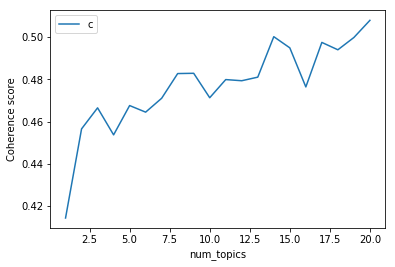

In [194]:
lda_model_list = evaluate_graph(id2word, corpus, data_lemmatized, 20)

In [248]:
# Looking at the coherence scores above,it appears to me that there are interesting clusters at 5, 8 & 13.
# We can have nearly 50% coherence.
# It is worth noting that according to the IDC-10 which classifies conditions, there are 25 classifications.

In [249]:
# Build LDA model
lda_model_5 = LdaMulticore(corpus=corpus,
                        id2word=id2word,
                        num_topics=5, 
                        random_state=100,
                        chunksize=2000,
                        passes=10,
                        per_word_topics=True)

# Compute Perplexity
print('Perplexity:', lda_model_5.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score using 'c_v'
coherence_model_lda = CoherenceModel(model=lda_model_5, texts=spacy_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity: -7.08146713747714
Coherence Score:  0.45886126105361813


In [250]:
coherence_model_lda = CoherenceModel(model=lda_model_5, texts=spacy_lemmatized, dictionary=id2word, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  -1.6175716456456826


In [251]:
# Build LDA model
lda_model_8 = LdaMulticore(corpus=corpus,
                        id2word=id2word,
                        num_topics=8, 
                        random_state=100,
                        chunksize=2000,
                        passes=10,
                        per_word_topics=True)

In [252]:
# Compute Perplexity
print('Perplexity:', lda_model_8.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score using 'c_v'
coherence_model_lda = CoherenceModel(model=lda_model_8, texts=spacy_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity: -7.086074633647405
Coherence Score:  0.46526153955253313


In [253]:
coherence_model_lda = CoherenceModel(model=lda_model_8, texts=spacy_lemmatized, dictionary=id2word, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  -1.7297158007539881


In [254]:
lda_model_13 = LdaMulticore(corpus=corpus,
                        id2word=id2word,
                        num_topics=13, 
                        random_state=100,
                        chunksize=2000,
                        passes=10,
                        per_word_topics=True)

In [257]:
# Compute Perplexity
print('Perplexity:', lda_model_13.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score using 'c_v'
coherence_model_lda = CoherenceModel(model=lda_model_13, texts=spacy_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity: -7.108283466924723
Coherence Score:  0.47506620134554


In [258]:
# Compute Coherence Score using u_mass

coherence_model_lda = CoherenceModel(model=lda_model_13, texts=spacy_lemmatized, dictionary=id2word, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  -1.9946462607549713


In [259]:
print(lda_model_5.print_topics())
doc_lda = lda_model_5[corpus]

print('-'*115)

print(lda_model_8.print_topics())
doc_lda = lda_model_8[corpus]

print('-'*115)

print(lda_model_13.print_topics())
doc_lda = lda_model_13[corpus]

[(0, '0.043*"pain" + 0.017*"year" + 0.015*"take" + 0.015*"work" + 0.015*"not" + 0.013*"day" + 0.010*"medication" + 0.010*"migraine" + 0.009*"drug" + 0.008*"get"'), (1, '0.030*"day" + 0.025*"take" + 0.016*"start" + 0.016*"not" + 0.015*"week" + 0.014*"go" + 0.013*"feel" + 0.013*"eat" + 0.010*"side_effect" + 0.010*"work"'), (2, '0.026*"feel" + 0.020*"take" + 0.016*"sleep" + 0.016*"not" + 0.015*"anxiety" + 0.015*"day" + 0.013*"get" + 0.012*"go" + 0.012*"work" + 0.011*"night"'), (3, '0.015*"day" + 0.015*"get" + 0.014*"use" + 0.014*"go" + 0.013*"not" + 0.012*"skin" + 0.011*"work" + 0.010*"bad" + 0.008*"burn" + 0.008*"month"'), (4, '0.028*"period" + 0.028*"get" + 0.026*"month" + 0.019*"not" + 0.016*"day" + 0.014*"week" + 0.012*"take" + 0.012*"birth_control" + 0.012*"first" + 0.012*"year"')]
-------------------------------------------------------------------------------------------------------------------
[(0, '0.066*"pain" + 0.017*"migraine" + 0.017*"work" + 0.016*"year" + 0.014*"day" + 0.014

In [260]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis1 = pyLDAvis.gensim.prepare(lda_model_5, corpus, id2word)
vis1

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.024897  0.060473       1        1  26.625439
4      0.129994  0.019828       2        1  21.014025
1      0.011658  0.079189       3        1  18.775553
0     -0.143340 -0.013211       4        1  18.316586
3      0.026585 -0.146278       5        1  15.268399, topic_info=     Category          Freq           Term         Total  loglift  logprob
209   Default  39490.000000           pain  39490.000000  30.0000  30.0000
81    Default  27201.000000         period  27201.000000  29.0000  29.0000
259   Default  19404.000000          sleep  19404.000000  28.0000  28.0000
140   Default  18327.000000        anxiety  18327.000000  27.0000  27.0000
114   Default  11249.000000            eat  11249.000000  26.0000  26.0000
169   Default  11278.000000  birth_control  11278.000000  25.0000  25.0000
430   Default  10741.000000          cramp  10741.000000  24.0000  24.0000
1060  Default   9681.000000           skin   9681.000000  23.0000  23.0000
63    Default   8295.000000          bleed   8295.000000  22.0000  22.0000
720   Default   8936.000000       migraine   8936.000000  21.0000  21.0000
93    Default  12225.000000     depression  12225.000000  20.0000  20.0000
61    Default  10769.000000           acne  10769.000000  19.0000  19.0000
1555  Default   5891.000000           burn   5891.000000  18.0000  18.0000
88    Default  11059.000000         weight  11059.000000  17.0000  17.0000
34    Default  49758.000000          month  49758.000000  16.0000  16.0000
376   Default  17783.000000          night  17783.000000  15.0000  15.0000
135   Default  21052.000000            use  21052.000000  14.0000  14.0000
15    Default  55802.000000           feel  55802.000000  13.0000  13.0000
827   Default   6030.000000           face   6030.000000  12.0000  12.0000
446   Default   4994.000000        product   4994.000000  11.0000  11.0000
883   Default   6928.000000          clear   6928.000000  10.0000  10.0000
13    Default  16355.000000           drug  16355.000000   9.0000   9.0000
440   Default   5087.000000     mood_swing   5087.000000   8.0000   8.0000
187   Default   6334.000000           spot   6334.000000   7.0000   7.0000
18    Default  67909.000000            get  67909.000000   6.0000   6.0000
387   Default   4208.000000          drink   4208.000000   5.0000   5.0000
404   Default   4239.000000       diarrhea   4239.000000   4.0000   4.0000
1563  Default   3567.000000           itch   3567.000000   3.0000   3.0000
279   Default  26963.000000     medication  26963.000000   2.0000   2.0000
729   Default  10866.000000         nausea  10866.000000   1.0000   1.0000
...       ...           ...            ...           ...      ...      ...
541    Topic5   2262.089111            eye   2795.490723   1.6677  -5.7255
1880   Topic5   2093.249023          cough   2598.419678   1.6632  -5.8031
1370   Topic5   1013.118958         vagina   1114.868286   1.7837  -6.5288
135    Topic5   9988.798828            use  21052.785156   1.1338  -4.2404
786    Topic5   2901.180420      treatment   4464.031250   1.4485  -5.4767
61     Topic5   5414.903320           acne  10769.593750   1.1918  -4.8527
7164   Topic5   1316.765015         pimple   1612.709595   1.6766  -6.2667
946    Topic5   2033.179810      infection   3079.998047   1.4641  -5.8322
766    Topic5   1868.847534     antibiotic   2803.208252   1.4739  -5.9165
62     Topic5   7261.233398            bad  31882.710938   0.3999  -4.5593
20     Topic5   9626.195312             go  53535.132812   0.1635  -4.2774
18     Topic5  10501.198242            get  67909.578125   0.0127  -4.1903
113    Topic5  10626.530273            day  79479.750000  -0.1328  -4.1785
37     Topic5   9209.632812            not  71872.984375  -0.1753  -4.3216
59     Topic5   7392.016602           work  47110.359375   0.0273  -4.5414
58     Topic5   4801.568359            try  26690.6015

In [261]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis2 = pyLDAvis.gensim.prepare(lda_model_8, corpus, id2word)
vis2

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.027700 -0.009575       1        1  18.753878
5     -0.071161 -0.090272       2        1  18.414278
4     -0.107994  0.051397       3        1  13.898211
7     -0.023236  0.041389       4        1  10.969968
0      0.079034  0.096370       5        1  10.778020
2     -0.073727  0.100506       6        1  10.663047
1     -0.055140 -0.152917       7        1   8.701648
3      0.224524 -0.036899       8        1   7.820951, topic_info=     Category          Freq           Term         Total  loglift  logprob
209   Default  40149.000000           pain  40149.000000  30.0000  30.0000
81    Default  26890.000000         period  26890.000000  29.0000  29.0000
259   Default  17972.000000          sleep  17972.000000  28.0000  28.0000
88    Default  12509.000000         weight  12509.000000  27.0000  27.0000
140   Default  18509.000000        anxiety  18509.000000  26.0000  26.0000
376   Default  16313.000000          night  16313.000000  25.0000  25.0000
114   Default  11114.000000            eat  11114.000000  24.0000  24.0000
169   Default  11141.000000  birth_control  11141.000000  23.0000  23.0000
34    Default  50870.000000          month  50870.000000  22.0000  22.0000
15    Default  54037.000000           feel  54037.000000  21.0000  21.0000
720   Default   9196.000000       migraine   9196.000000  20.0000  20.0000
93    Default  13151.000000     depression  13151.000000  19.0000  19.0000
119   Default   9789.000000           lose   9789.000000  18.0000  18.0000
792   Default  18588.000000           hour  18588.000000  17.0000  17.0000
1060  Default   9423.000000           skin   9423.000000  16.0000  16.0000
113   Default  76801.000000            day  76801.000000  15.0000  15.0000
63    Default   8202.000000          bleed   8202.000000  14.0000  14.0000
430   Default  11565.000000          cramp  11565.000000  13.0000  13.0000
90    Default  46338.000000           year  46338.000000  12.0000  12.0000
61    Default  10362.000000           acne  10362.000000  11.0000  11.0000
1527  Default   6489.000000          rsquo   6489.000000  10.0000  10.0000
1555  Default   5775.000000           burn   5775.000000   9.0000   9.0000
87    Default  43996.000000           week  43996.000000   8.0000   8.0000
547   Default   4934.000000             lb   4934.000000   7.0000   7.0000
55    Default  72252.000000           take  72252.000000   6.0000   6.0000
827   Default   5879.000000           face   5879.000000   5.0000   5.0000
446   Default   4962.000000        product   4962.000000   4.0000   4.0000
135   Default  21168.000000            use  21168.000000   3.0000   3.0000
70    Default   6239.000000           gain   6239.000000   2.0000   2.0000
729   Default   9686.000000         nausea   9686.000000   1.0000   1.0000
...       ...           ...            ...           ...      ...      ...
13     Topic8   3658.748779           drug  16193.518555   1.0609  -4.5763
1569   Topic8    970.354797          swell   1945.812256   1.8526  -5.9036
819    Topic8   1285.290894          level   3085.290527   1.6727  -5.6225
90     Topic8   6825.935059           year  46338.054688   0.6331  -3.9527
1139   Topic8   1174.133057       hospital   2711.398193   1.7114  -5.7129
295    Topic8   2027.681519          cause   7388.434570   1.2553  -5.1666
338    Topic8   2340.193115        symptom   9724.236328   1.1240  -5.0232
34     Topic8   5490.834961          month  50870.324219   0.3222  -4.1704
614    Topic8   1249.115356            leg   3423.521484   1.5401  -5.6510
55     Topic8   5457.954102           take  72252.750000  -0.0347  -4.1764
410    Topic8   1390.114258           high   4538.465820   1.3652  -5.5441
87     Topic8   3861.438232           week  43996.578125   0.1153  -4.5224
279    Topic8   3025.191162     medication  26926.511719   0.3622  -4.7665
133    Topic8   2601.072998           stop

In [262]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis3 = pyLDAvis.gensim.prepare(lda_model_13, corpus, id2word)
vis3

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11    -0.032981 -0.055300       1        1  15.715347
5     -0.075981 -0.003776       2        1  15.463671
4     -0.125268  0.077893       3        1  11.081228
9      0.101816 -0.100820       4        1   8.690069
0      0.057402 -0.004156       5        1   7.554074
7     -0.061844  0.019069       6        1   7.106260
3     -0.034184 -0.055155       7        1   6.674546
2     -0.141425 -0.005035       8        1   6.216425
10    -0.128977  0.049973       9        1   4.883612
6      0.071788 -0.179244      10        1   4.519431
1     -0.025646  0.020214      11        1   4.208730
8      0.226711 -0.056439      12        1   4.152296
12     0.168589  0.292777      13        1   3.734302, topic_info=     Category          Freq           Term         Total  loglift  logprob
209   Default  40709.000000           pain  40709.000000  30.0000  30.0000
259   Default  17268.000000          sleep  17268.000000  29.0000  29.0000
81    Default  27565.000000         period  27565.000000  28.0000  28.0000
376   Default  16279.000000          night  16279.000000  27.0000  27.0000
1215  Default  10941.000000            amp  10941.000000  26.0000  26.0000
113   Default  77600.000000            day  77600.000000  25.0000  25.0000
88    Default  12336.000000         weight  12336.000000  24.0000  24.0000
140   Default  18916.000000        anxiety  18916.000000  23.0000  23.0000
90    Default  45718.000000           year  45718.000000  22.0000  22.0000
15    Default  55235.000000           feel  55235.000000  21.0000  21.0000
34    Default  50308.000000          month  50308.000000  20.0000  20.0000
114   Default  10860.000000            eat  10860.000000  19.0000  19.0000
792   Default  18386.000000           hour  18386.000000  18.0000  18.0000
87    Default  44335.000000           week  44335.000000  17.0000  17.0000
55    Default  72538.000000           take  72538.000000  16.0000  16.0000
1060  Default   9134.000000           skin   9134.000000  15.0000  15.0000
169   Default  10895.000000  birth_control  10895.000000  14.0000  14.0000
720   Default   6773.000000       migraine   6773.000000  13.0000  13.0000
119   Default   9681.000000           lose   9681.000000  12.0000  12.0000
1527  Default   6565.000000          rsquo   6565.000000  11.0000  11.0000
59    Default  47040.000000           work  47040.000000  10.0000  10.0000
18    Default  67409.000000            get  67409.000000   9.0000   9.0000
93    Default  13076.000000     depression  13076.000000   8.0000   8.0000
51    Default  31449.000000    side_effect  31449.000000   7.0000   7.0000
61    Default   9687.000000           acne   9687.000000   6.0000   6.0000
396   Default   6219.000000           wake   6219.000000   5.0000   5.0000
279   Default  27084.000000     medication  27084.000000   4.0000   4.0000
135   Default  21024.000000            use  21024.000000   3.0000   3.0000
547   Default   4936.000000             lb   4936.000000   2.0000   2.0000
430   Default  11507.000000          cramp  11507.000000   1.0000   1.0000
...       ...           ...            ...           ...      ...      ...
1447  Topic13    608.681213         tingle    868.667847   2.9319  -5.6300
1351  Topic13    940.155884          joint   1567.321533   2.7765  -5.1952
2610  Topic13    734.424316        swollen   1180.551758   2.8130  -5.4422
3454  Topic13    246.472549        dentist    295.638184   3.1057  -6.5340
771   Topic13   1364.226562      injection   2920.269287   2.5265  -4.8229
1965  Topic13    329.532166          ankle    441.047394   2.9961  -6.2436
1038  Topic13    858.365662           neck   1828.330078   2.5315  -5.2862
800   Topic13    639.562195           ache   1226.449951   2.6365  -5.5805
1611  Topic13    934.403564          chest   2223.313477   2.4208  -5.2014
1717  Topic13    649.477356           knee   1328.127686   2.5723  -5.56

In [286]:
# Loop through different topics to get coherence scores for a range of possible topics
def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Function to display num_topics - LDA graph using c_v coherence
    """
    topics = [5,10,15,20,25,30,35]
    c_v = []
    lda_model_list = []
    for x in tqdm(topics):
        lda_model = LdaMulticore(corpus=corpus, num_topics= x, id2word=id2word, random_state=100, chunksize=2000, passes=5, per_word_topics=True)
        lda_model_list.append( lda_model )
        coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
        c_v.append(coherence_model_lda.get_coherence())
        
    # Show graph
    x = topics
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lda_model_list

100%|██████████| 7/7 [39:32<00:00, 353.28s/it]


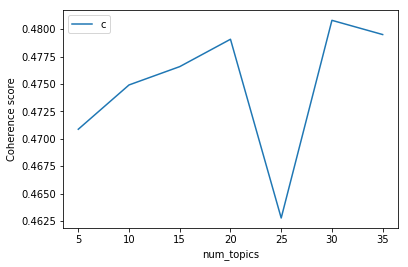

In [283]:
lda_model_list = evaluate_graph(id2word, corpus, data_lemmatized, 35)

In [64]:
# It is worth note that I tried to run a K-means clustering algorithim on the entire corpus for a K-range of 21.
# However after it ran for 18 hours, and reached 60% completion, my computer crashed. Hence, I will rely on LDA 
# coherence scores. That coupled with my own intuition, I will then build create new classes for the conditions. 
# Moving forward I will go ahead with 8 classes. It is interesting that at 25 classes, which is in the IDC-10, we actually have a signficant dip.


# Classifying Conditions using Reviews

In [ ]:
# Now that 8 topics is my new criterian for number of categories.

In [432]:
df = pd.read_csv("bigdata_clean.csv", index_col=0)

In [433]:
df['condition'].value_counts(ascending=False)[:50].sum()

97205

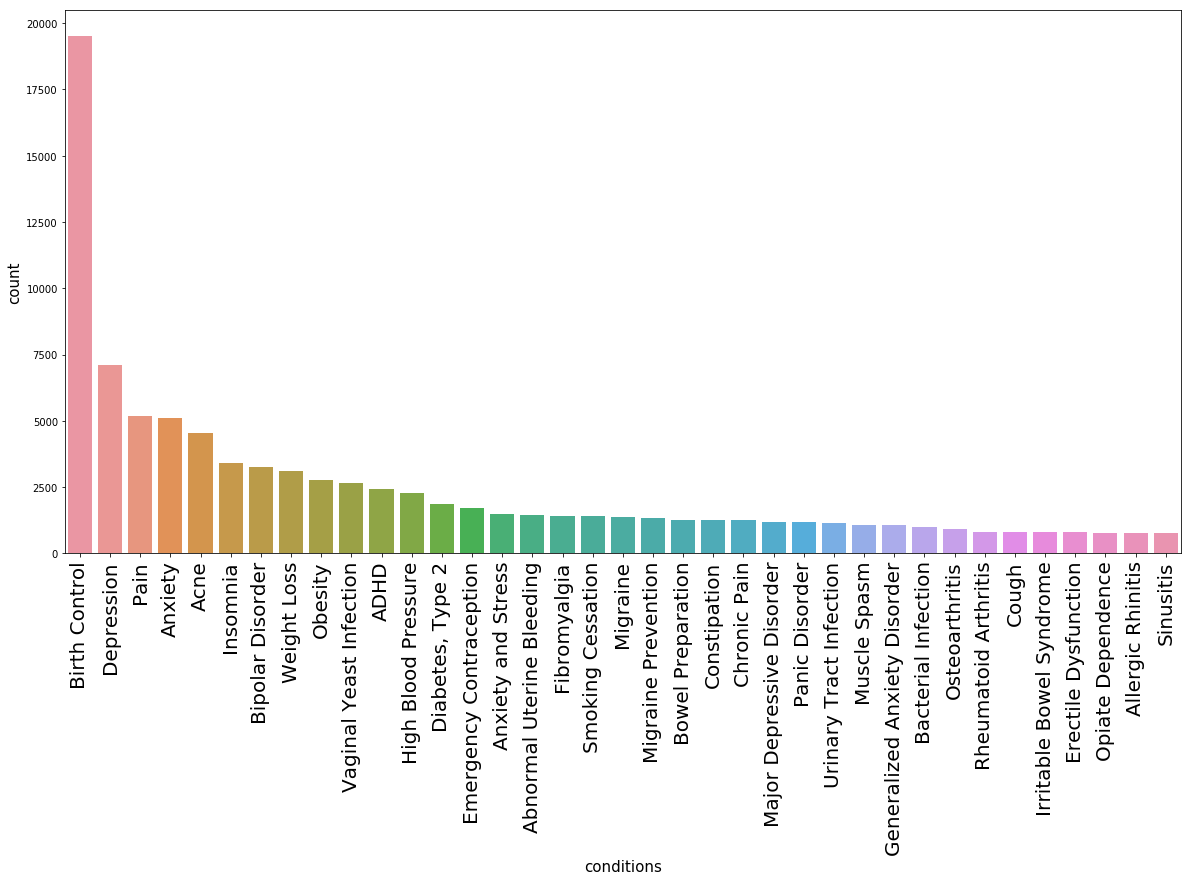

In [434]:
condition_df = df.groupby('condition').filter(lambda x: len(x) > 750) # I wanted to explore condiitons that appeared at least 750 times.
conditions = condition_df['condition'].value_counts().index.tolist()
fig, ax = plt.subplots(figsize = (20, 10))
sns.countplot(x = condition_df['condition'], order = conditions, ax = ax)
plt.xticks(rotation = 90, fontsize=20)
plt.xlabel('conditions', fontsize=15)
plt.ylabel('count' , fontsize=15)
plt.show()

In [435]:
condition_df['condition'].unique()

array(['Depression', 'Birth Control', 'Weight Loss', 'Pain',
       'Anxiety and Stress', 'Anxiety', 'Obesity', 'Panic Disorder',
       'Urinary Tract Infection', 'Muscle Spasm', 'Bipolar Disorder',
       'Insomnia', 'Opiate Dependence', 'High Blood Pressure', 'ADHD',
       'Fibromyalgia', 'Erectile Dysfunction',
       'Generalized Anxiety Disorder', 'Rheumatoid Arthritis',
       'Abnormal Uterine Bleeding', 'Constipation', 'Osteoarthritis',
       'Sinusitis', 'Diabetes, Type 2', 'Emergency Contraception',
       'Chronic Pain', 'Vaginal Yeast Infection', 'Migraine',
       'Migraine Prevention', 'Acne', 'Bacterial Infection',
       'Irritable Bowel Syndrome', 'Major Depressive Disorder',
       'Allergic Rhinitis', 'Smoking Cessation', 'Cough',
       'Bowel Preparation'], dtype=object)

In [436]:
condition_df = condition_df[['clean_condition' , 'review_stemmed']] # Create a new dataframe.

In [437]:
condition_df = condition_df[~condition_df['clean_condition'].str.contains("not listed")] # Drop the conditions that are not listed.

In [438]:
condition_df

,clean_condition,review_stemmed
0,depression,rememb read peopl opinion onlin drug took scare away final decid give tri best choic made month feel great side effect first start notic hand would trembl subsid honest listen negat work work amaz other go base youself not everyon els may bless diguis not meant make happi go lucki see butterfli rose meant help put chemic mind balanc not over depress still get sad time normal life peopl control make chang get
1,birth control,iud year think best thing ever first got put bled week littl cramp noth period month final got not bad light no cramp no headach noth gain weight acn gone mood fine know women differ hear horror stori want tell stori good hope calm fear
2,depression,zoloft two year relax easi go person zoloft prior start medicin anxious time worri constant everyth suffer period depress hopeless better wife friend person general
3,weight loss,use past year say best lose weight thing ever work gain least pound pregnanc time child massiv amount weight lose time go right back size within month no exercis tip take long follow alway way breakfast first thing morn realli want get result eat carb breakfast never go take day stop gain back must wean slowli fine
4,depression,respond week side effect lethargi bowel problem reason didnt rate medicin year excess anxieti depress final feel like instead enslav unreason thought frustrat iron avoid type med year instead self medic alcohol cynic switch year ago mayb would still marri wonder woman sad true
5,birth control,nervous tri implanon read negat review went ahead anyway procedur quick practic painless spot tender day ugli bruis tini scar noth terribl start implanon period last week give bleed minim bad period end noth period sinc devic insert decemb notic weight gain unusu moodi best birth control ever advic give chanc let negat review scare away
6,pain,ahhhh dread drug no matter call whatev media scare tactic trumpet success stori someth negat garner press stori two brain surgeri manmouth amount pain tri everyth noth last like drug allow go back work live life father children screw strang look pharmaci aliv
7,depression,lot addit stress ad last year death parent lot hurt thing parent spous cheat everyday thing like stress young children school sport etc year tri everi antidepress either work made feel like zombi alway made sex drive go zero given everi prescript not taken anyth almost year no energi much get annoy aggrav peopl includ kid feel lot joy tri viibryd feel great great energi lose temper kid husband still sex drive
8,anxiety and stress,work larg fire depart tough time bad call no sleep alway feel like troubl like drown no help put celexa life came back worri thing need worri stress thing stress feel normal believ save career
9,depression,year old take zoloft year miracl medicin find much even keel thing still upset far less without zoloft find much ration thought process confid choic make sever medic condit contribut feel depress overwhelm yes even suicid sinc began therapi zoloft want live without zoloft not encourag anyon feel depress seek help find right medic life hard enough without cope feel sever negat emot grate whoever creat zoloft


In [439]:
# 1. Natural Clustering for Mental Health
replaceDict = [('depression', 'mental health') , ('panic disorder', 'mental health'), 
               ('bipolar disorder', 'mental health') , ('adhd', 'mental health') , 
               ('major depressiver disorder', 'mental health') , 
               ('anxiety and stress' , 'mental health'),
               ('anxiety','mental health'), ('generalized anxiety disorder', 'mental health'),  
               ('insomnia', 'mental health'), ('major depressive disorder', 'mental health')] 
for key, replacement in replaceDict:    
    condition_df =  condition_df.replace( key, replacement )

In [440]:
# 2. Groupings of addictions
replaceDict = [('opiate dependence', 'addiction'), ('smoking cessation', 'addiction')]
for key, replacement in replaceDict:
    condition_df =  condition_df.replace( key, replacement )

In [441]:
# 3. These are all ear nose mouth or throat types.
replaceDict = [('allergic rhinitis', 'enmt'), ('cough', 'enmt'), ('migraine', 'enmt') , ('migraine prevention' , 'enmt'),
               ('sinusitis', 'enmt'), ('nausea vomiting', 'enmt'), ('bacterial infection' , 'enmt')]
for key, replacement in replaceDict:
    condition_df =  condition_df.replace( key, replacement )

In [442]:
# 4. Female specific... could classify urinatry tract infection in male's but more female specific .
replaceDict = [('birth control', 'female specific'), ('vaginal yeast infection', 'female specific'), 
               ('emergency contraception', 'female specific'), ('bacterial vaginitis', 'female specific'), 
               ('abnormal uterine bleeding', 'female specific'), ("urinary tract infection" , "female specific")]
for key, replacement in replaceDict:
    condition_df =  condition_df.replace( key, replacement )

In [443]:
# 5. Male Specific
replaceDict = [('erectile dysfunction', 'male specific')]
for key, replacement in replaceDict:
    condition_df =  condition_df.replace( key, replacement )

In [444]:
# 6. GastroIntestinal (Stomach - Nutrition)
replaceDict = [('weight loss', 'gi'), ('obesity', 'gi'), ('constipation', 'gi'), ('bowel preparation', 'gi'), 
               ('diabetes type', 'gi'), ('irritable bowel syndrome', 'gi'), ('high blood pressure', 'gi')]
for key, replacement in replaceDict:
    condition_df =  condition_df.replace( key, replacement )

In [445]:
# 7. Muscoloskeletal 
replaceDict = [('pain', 'muscoloskeletal'), ('chronic pain', 'muscoloskeletal'),
               ('rheumatoid arthritis', 'muscoloskeletal'),
               ('muscle spasm', 'muscoloskeletal'), ('fibromyalgia', 'muscoloskeletal') , 
               ('osteoarthritis', 'muscoloskeletal')]
for key, replacement in replaceDict:
    condition_df=  condition_df.replace( key, replacement )

In [446]:
# 8. Skin related.
replaceDict = [('acne', 'dermatology')]
for key, replacement in replaceDict:
    condition_df =  condition_df.replace( key, replacement )

In [447]:
condition_df['clean_condition'].unique()

array(['mental health', 'female specific', 'gi', 'muscoloskeletal',
       'addiction', 'male specific', 'enmt', 'dermatology'], dtype=object)

In [448]:
from nltk.corpus import stopwords
stoplist2 = stopwords.words('english')
stoplist2.extend(['from', 'mg', 'pill', 'medication', 'medicine', 'diagnose', 'try', 'ive', 're', 'edu', 'use','one', 'br', 'Po', 'th', 'sayi', 'fo', 'unknown', 'take', 'take', 'taken,' 'get' ])
len(stoplist2)

# I am going to add a few more words like pill, mediciation, medicine to the stopwors list

200

In [449]:
list_corpus = condition_df["review_stemmed"].astype('U').tolist()
list_labels = condition_df["clean_condition"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.25, random_state=22)

In [477]:
tfv = TfidfVectorizer(min_df=10, max_features=None, analyzer='word',
                     ngram_range=(1, 2), use_idf=True, smooth_idf=True, sublinear_tf=True, stop_words = stoplist2)
    
X_train = tfv.fit_transform(X_train)
X_test = tfv.transform(X_test)

logit = LogisticRegression(class_weight='balanced', random_state=42)
logit.fit(X_train, y_train)
y_pred = logit.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

                 precision    recall  f1-score   support

      addiction       0.92      0.87      0.90       558
    dermatology       0.90      0.89      0.89      1174
           enmt       0.79      0.84      0.82      1542
female specific       0.97      0.93      0.95      6589
             gi       0.90      0.90      0.90      3393
  male specific       0.64      0.83      0.72       198
  mental health       0.91      0.93      0.92      6459
muscoloskeletal       0.86      0.86      0.86      2665

      micro avg       0.91      0.91      0.91     22578
      macro avg       0.86      0.88      0.87     22578
   weighted avg       0.91      0.91      0.91     22578

[[ 488    1    4    2    7    4   34   18]
 [   0 1043    3   86   15    5   15    7]
 [   3    3 1294   15   57    5  101   64]
 [   2   99  105 6149   57    7  115   55]
 [   6    3   68   40 3051   20  122   83]
 [   0    1    4    3    8  165   11    6]
 [  24    6   77   51  138   30 6001  132]
 [   6    1 

In [478]:
list_corpus = condition_df["review_stemmed"].astype('U').tolist()
list_labels = condition_df["clean_condition"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.25, random_state=22)

vectorizer = TfidfVectorizer(min_df=10, max_features=None, analyzer='word',
                     ngram_range=(1, 2), use_idf=True, smooth_idf=True, sublinear_tf=True, stop_words = stoplist2)

In [479]:
pipeline = Pipeline([('vect', vectorizer),
                     ('chi',  SelectKBest(chi2, k=5000)),
                     ('clf', RandomForestClassifier(n_estimators=300, max_depth=100, class_weight='balanced'))])

model = pipeline.fit(X_train, y_train)
ytest = np.array(y_test)
# confusion matrix and classification report(precision, recall, F1-score)
print(classification_report(ytest, model.predict(X_test)))
print(confusion_matrix(ytest, model.predict(X_test)))

                 precision    recall  f1-score   support

      addiction       0.94      0.86      0.89       541
    dermatology       0.92      0.86      0.89      1166
           enmt       0.79      0.74      0.76      1476
female specific       0.95      0.92      0.93      6722
             gi       0.87      0.83      0.85      3335
  male specific       0.84      0.72      0.77       208
  mental health       0.85      0.92      0.88      6500
muscoloskeletal       0.80      0.83      0.81      2630

      micro avg       0.88      0.88      0.88     22578
      macro avg       0.87      0.83      0.85     22578
   weighted avg       0.88      0.88      0.88     22578

[[ 464    2    1    3    4    0   50   17]
 [   0 1000    5  125    9    0   18    9]
 [   2    8 1088   42   73    0  174   89]
 [   4   53   61 6170   83    3  255   93]
 [   8    7   63   56 2779    8  268  146]
 [   0    0    5    3   10  149   26   15]
 [  15   11   60   84  165   14 5964  187]
 [   3    3 

In [473]:
from sklearn.neural_network import MLPClassifier

In [474]:
X = condition_df['review_stemmed'].astype('U')
Y = condition_df['clean_condition']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

vectorizer = TfidfVectorizer(min_df=10, max_features=None, analyzer='word',
                     ngram_range=(1, 2), use_idf=True, smooth_idf=True, sublinear_tf=True, stop_words = stoplist2)

In [476]:
X = condition_df['review_stemmed'].astype('U')
Y = condition_df['clean_condition']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

# Lets use a MLP Classifier from the sklearns neural network 
pipeline = Pipeline([('vect', vectorizer),
                     ('clf', MLPClassifier())])
# fitting our model 
model = pipeline.fit(X_train, y_train)
ytest = np.array(y_test)
# confusion matrix and classification report
print(classification_report(ytest, model.predict(X_test)))
print(confusion_matrix(ytest, model.predict(X_test)))

                 precision    recall  f1-score   support

      addiction       0.96      0.84      0.90       558
    dermatology       0.92      0.85      0.89      1174
           enmt       0.83      0.77      0.80      1542
female specific       0.95      0.95      0.95      6589
             gi       0.88      0.90      0.89      3393
  male specific       0.88      0.75      0.81       198
  mental health       0.89      0.93      0.91      6459
muscoloskeletal       0.85      0.84      0.84      2665

      micro avg       0.90      0.90      0.90     22578
      macro avg       0.89      0.85      0.87     22578
   weighted avg       0.90      0.90      0.90     22578

[[ 470    1    6    5   16    2   41   17]
 [   0 1001    9  125   15    0   16    8]
 [   2    2 1184   46   80    1  134   93]
 [   1   70   52 6251   64    0  105   46]
 [   1    2   50   52 3050    5  170   63]
 [   0    1    5    4    9  148   19   12]
 [  12    3   57   64  165   10 5976  172]
 [   3    3 

In [428]:
X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=22)

#classifier
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier()),
])

parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'clf__max_iter': (5,),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet')
}

if __name__ == "__main__":
    
    grid_search = GridSearchCV(pipeline, parameters, cv=5,
                               n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(parameters)
    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'vect__max_df': (0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'clf__max_iter': (5,), 'clf__alpha': (1e-05, 1e-06), 'clf__penalty': ('l2', 'elasticnet')}
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 13.8min finished


done in 851.234s

Best score: 0.915
Best parameters set:
	clf__alpha: 1e-05
	clf__max_iter: 5
	clf__penalty: 'elasticnet'
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)


In [480]:
# These are very good results. 

# In rapping up the key conclussions, I have learned that sentiment isn't a great predictor of rating, however using TFIDF or a CountVect
# I was able to predict rating at a 10% higher clip.

# Through using LDA, I found that there were 8 topics. I then reclassified the conditions into 8 groups and predicted the condition as one 
# of 8 classes with over 90% f1 scores. 

-------------